# Tangerang house price prediction

# 

## Table Of Contents
• Introduction <br>
• Data Preparation<br>
• Basic exploratory data analysis <br>
&nbsp;&nbsp;&nbsp; • Descriptive statistic <Br>
&nbsp;&nbsp;&nbsp; • Univariate analysis <br>
&nbsp;&nbsp;&nbsp; • Multivariate analysis <br>
• Deep-dive exploratory data analysis <br>
• Modelling<br>
&nbsp;&nbsp;&nbsp; • Model building combination 1 <Br> 
&nbsp;&nbsp;&nbsp; • Model building combination 2 <Br>
&nbsp;&nbsp;&nbsp; • Model building combination 3 <Br>
&nbsp;&nbsp;&nbsp; • Model building combination 4 <Br> 
&nbsp;&nbsp;&nbsp; • Model building combination 5 <Br>
&nbsp;&nbsp;&nbsp; • Model building combination 6 <Br> 
• Choosing the best model combination <br>
• Model evaluation and interpretation <br>
&nbsp;&nbsp;&nbsp; • Residuals plot <Br>
&nbsp;&nbsp;&nbsp; • PDP & ICE plots <Br>
• Conclusion <br>

## Introduction
This project revolves around predicting house prices in Tangerang City, which encompasses more than 40 regions. The data for this project was gathered by scraping information from one of Indonesia's largest online real estate listing platforms. After conducting this exploratory phase, I will deploy an application publicly to assist people in estimating house prices.

## Data Preparation
Importing libraries, cleaning data and choosing features.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import ast
import re
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import plotly.express as px
import matplotlib.patches as mpatches
from pdpbox import pdp

#set some library settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set()
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 150 
plt.rc('legend',**{'fontsize':10})

In [2]:
#read csv
df = pd.read_csv('tangerang.csv')

In [3]:
#first look of data
df.head()

harga               alamat  \
0   Rp 2,6 Miliar  BSD City, Tangerang   
1    Rp 20 Miliar  BSD City, Tangerang   
2  Rp 1,68 Miliar  BSD City, Tangerang   
3  Rp 1,61 Miliar  BSD City, Tangerang   
4  Rp 2,14 Miliar  BSD City, Tangerang   

                                           fasilitas  \
0  Tempat Jemuran,Keamanan 24 jam,Playground,Wast...   
1                                                NaN   
2               Taman,Tempat Jemuran,Keamanan 24 jam   
3               Taman,Tempat Jemuran,Keamanan 24 jam   
4               Taman,Tempat Jemuran,Keamanan 24 jam   

                                         spesifikasi  
0  [['Kamar Tidur', '3'], ['Kamar Mandi', '2'], [...  
1  [['Kamar Tidur', '5'], ['Kamar Mandi', '5'], [...  
2  [['Kamar Tidur', '2'], ['Kamar Mandi', '2'], [...  
3  [['Kamar Tidur', '4'], ['Kamar Mandi', '3'], [...  
4  [['Kamar Tidur', '3'], ['Kamar Mandi', '3'], [...

In [4]:
#change 'spesifikasi' to type list and explode it to become columns
df['spesifikasi'] = df.spesifikasi.apply(ast.literal_eval)
df = df.explode('spesifikasi')

In [5]:
#split into 'keterangan' and 'qty'
df['keterangan'] = df.spesifikasi.str[0]
df['qty'] = df.spesifikasi.str[1]

In [6]:
df_columns = df[['harga','alamat','fasilitas']].reset_index().drop_duplicates('index').set_index('index')
df_pivot = df.pivot(columns='keterangan', values='qty').rename_axis(None, axis=1)
df = pd.concat([df_columns, df_pivot], axis = 1)

> Code above is about to transform 'keterangan' into several columns.

In [7]:
#new transformed dataframe
df.head()

harga               alamat  \
0   Rp 2,6 Miliar  BSD City, Tangerang   
1    Rp 20 Miliar  BSD City, Tangerang   
2  Rp 1,68 Miliar  BSD City, Tangerang   
3  Rp 1,61 Miliar  BSD City, Tangerang   
4  Rp 2,14 Miliar  BSD City, Tangerang   

                                           fasilitas Carport Dapur  \
0  Tempat Jemuran,Keamanan 24 jam,Playground,Wast...       1   NaN   
1                                                NaN     NaN     2   
2               Taman,Tempat Jemuran,Keamanan 24 jam       1     1   
3               Taman,Tempat Jemuran,Keamanan 24 jam       1     1   
4               Taman,Tempat Jemuran,Keamanan 24 jam       1     1   

  Daya Listrik Garasi       Hadap   Hook     ID Iklan Jumlah Lantai  \
0          NaN    NaN         NaN  Tidak  hos14814642             1   
1    7700 Watt    NaN         NaN  Tidak  hos13101318             2   
2    1300 Watt    NaN       Utara  Tidak  hos14850708             1   
3    2200 Watt    NaN  Timur Laut  Tidak  hos14850789             2   
4    5500 Watt    NaN       Utara  Tidak  hos14003997             3   

  Kamar Mandi Kamar Mandi Pembantu Kamar Pembantu Kamar Tidur  \
0           2                    2              1           3   
1           5                    1              1           5   
2           2                  NaN            NaN           2   
3           3                  NaN            NaN           4   
4           3                  NaN              1           3   

  Kondisi Perabotan Kondisi Properti Konsep dan Gaya Rumah Lebar Jalan  \
0               NaN            Bagus      Minimalis Modern     3 Mobil   
1       Unfurnished            Bagus                   NaN         NaN   
2       Unfurnished            Bagus                   NaN         NaN   
3       Unfurnished            Bagus                   NaN         NaN   
4       Unfurnished            Bagus                   NaN         NaN   

  Luas Bangunan Luas Tanah Material Bangunan Material Lantai Nomor Lantai  \
0         91 m²      91 m²            Batako          Granit          NaN   
1        465 m²     396 m²               NaN             NaN          NaN   
2         70 m²     105 m²               NaN             NaN          NaN   
3        174 m²     144 m²               NaN             NaN          NaN   
4        170 m²     105 m²               NaN             NaN          NaN   

  Pemandangan Periode Sewa Ruang Makan Ruang Tamu  \
0  Taman Kota          NaN          Ya         Ya   
1         NaN          NaN          Ya         Ya   
2         NaN          NaN          Ya         Ya   
3         NaN          NaN          Ya         Ya   
4         NaN          NaN          Ya         Ya   

                      Sertifikat     Sumber Air Tahun Di Renovasi  \
0  Lainnya (PPJB,Girik,Adat,dll)  PAM atau PDAM               NaN   
1  Lainnya (PPJB,Girik,Adat,dll)  PAM atau PDAM               NaN   
2        HGB - Hak Guna Bangunan  PAM atau PDAM               NaN   
3     SHM - Sertifikat Hak Milik  PAM atau PDAM               NaN   
4     SHM - Sertifikat Hak Milik  PAM atau PDAM               NaN   

  Tahun Dibangun Terjangkau Internet Tipe Properti  
0            NaN                  Ya         Rumah  
1            NaN               Tidak         Rumah  
2            NaN               Tidak         Rumah  
3            NaN               Tidak         Rumah  
4            NaN               Tidak         Rumah

In [8]:
#remove duplicate data / 'iklan' (ads)
df = df.drop_duplicates('ID Iklan').reset_index(drop=True)

In [9]:
df.insert(3, 'komplek', df[['fasilitas']].fillna('none').apply(lambda z: 'ya' if any([x in z.fasilitas.lower() for x in ['lapangan','gym','jogging','playground','one gate system']]) else 'tidak', axis = 1))
df.insert(1, 'Kecamatan', df.alamat.str.split(',').str[0])
df.insert(2, 'Kota', df.alamat.str.split(',').str[1])
df.drop(columns=['alamat','fasilitas'], inplace=True)

> Create 3 new columns:<Br>
1.'komplek' = check if the house is in a 'komplek' or not.<br>
2.'Kecamatan' = 'kecamatan' of the address.<br>
3.'Kota' = 'kota' of the address.

In [10]:
#ensure the selected city is Tangerang
df = df[df.Kota == ' Tangerang']
df.drop(columns = ['Kota'], inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22667 entries, 0 to 22673
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   harga                  22667 non-null  object
 1   Kecamatan              22667 non-null  object
 2   komplek                22667 non-null  object
 3   Carport                14104 non-null  object
 4   Dapur                  12157 non-null  object
 5   Daya Listrik           18287 non-null  object
 6   Garasi                 6450 non-null   object
 7   Hadap                  8528 non-null   object
 8   Hook                   18764 non-null  object
 9   ID Iklan               22667 non-null  object
 10  Jumlah Lantai          20569 non-null  object
 11  Kamar Mandi            21871 non-null  object
 12  Kamar Mandi Pembantu   8945 non-null   object
 13  Kamar Pembantu         9597 non-null   object
 14  Kamar Tidur            21864 non-null  object
 15  Kondisi Perabotan      1

***
>There are 29 missing columns. After carefully reviewing each house one by one in the context, I categorized the missing columns into: <Br>

>1.Missing Completely At Random<br>
This means that the values are not input by the users due to accidents, forgetfulness, or oversight. These columns are: <br>
Daya Listrik, Kamar Mandi, Kamar Tidur, Luas Bangunan, Luas Tanah, Sertifikat, Sumber Air, Hook

>2.Missing At Random<br>
This means that the values are not input by the users because these values can be obtained from other sources, such as photos or other information. These columns are: <br>
Carport, Dapur, Garasi, Kamar Mandi Pembantu, Kamar Pembantu, Kondisi Perabotan, Kondisi Properti, Jumlah Lantai, Ruang Makan, Ruang Tamu

>3.Missing Not At Random<br>
This means that the values are not input by the users because they either do not know the value or they perceive it as unimportant to input the value. These columns are: <br>
Konsep dan Gaya Rumah, Hadap, Lebar Jalan, Material Bangunan, Material Lantai, Nomor Lantai, Pemandangan, Periode Sewa, Tahun Di Renovasi, Tahun Dibangun, Terjangkau Internet
***

In [12]:
#create a function to categorize multiple 'perabot' conditions into more general category
def perabot(kondisi):
    kondisi = str(kondisi)
    if kondisi.lower() in ['unfurnished','butuh renovasi']:
        return 'Unfurnished'
    elif kondisi.lower() in ['furnished','bagus','bagus sekali','baru','sudah renovasi','semi furnished']:
        return 'Furnished'
    else:
        return np.nan

df['Kondisi Perabotan'] = df[['Kondisi Perabotan']].apply(lambda x: perabot(x['Kondisi Perabotan']), axis = 1)

In [13]:
#filtered only houses and not other property
df = df[df['Tipe Properti'] == 'Rumah']

In [14]:
#extract prices from column 'harga' into integer
def price_extract(price):
    if "Triliun" in price:
        numbers = re.findall(r'\d+\.\d+|\d+', price)
        numbers = float(".".join(numbers))
        return int(numbers * 1000000)
    elif "Miliar" in price:
        numbers = re.findall(r'\d+\.\d+|\d+', price)
        numbers = float(".".join(numbers))
        return int(numbers * 1000)
    elif "Juta" in price:
        numbers = re.findall(r'\d+\.\d+|\d+', price)
        numbers = float(".".join(numbers))
        return int(numbers * 1)      

df.insert(1, 'price',  df[['harga']].apply(lambda x: price_extract(x.harga), axis = 1))
df.drop(columns = ['harga'], inplace = True)

>Here, I converted the 'price' column into integers and divided it by one million to make it easier to view and analyze.

In [15]:
#move 'ID Iklan' column to left
df.insert(3, 'ID',  df['ID Iklan'])

In [16]:
#filter Sertifikat to SHM only
df = df[df.Sertifikat == 'SHM - Sertifikat Hak Milik']

In [17]:
#drop useless columns
df.drop(columns=['Kondisi Properti','Sertifikat','Hook','ID Iklan','Lebar Jalan','Dapur','Tipe Properti','Terjangkau Internet','Sumber Air','Ruang Tamu','Ruang Makan','Carport','Garasi','Tahun Di Renovasi','Tahun Dibangun','Hadap','Konsep dan Gaya Rumah','Material Bangunan','Material Lantai','Nomor Lantai','Pemandangan','Periode Sewa'], inplace = True, errors='ignore')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17746 entries, 3 to 22673
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   price                 17746 non-null  int64 
 1   Kecamatan             17746 non-null  object
 2   komplek               17746 non-null  object
 3   ID                    17746 non-null  object
 4   Daya Listrik          14640 non-null  object
 5   Jumlah Lantai         16312 non-null  object
 6   Kamar Mandi           17110 non-null  object
 7   Kamar Mandi Pembantu  6714 non-null   object
 8   Kamar Pembantu        7296 non-null   object
 9   Kamar Tidur           17103 non-null  object
 10  Kondisi Perabotan     12942 non-null  object
 11  Luas Bangunan         17719 non-null  object
 12  Luas Tanah            17743 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.9+ MB


In [19]:
df = df[~df['Luas Tanah'].isna()].reset_index(drop=True)
df = df[~((df['Kamar Mandi'].isna()) & (df['Kamar Mandi Pembantu'].isna()) & (df['Kamar Pembantu'].isna()) & (df['Kamar Tidur'].isna()))].reset_index(drop=True)

> I removed rows that lacked critical information, such as 'Luas Tanah' and the total number of 'Kamar'.

In [20]:
for kol in ['Kamar Mandi','Kamar Tidur']:
    df[kol] = df[kol].fillna(1)

df['Luas Bangunan'] = df['Luas Bangunan'].fillna(df['Luas Tanah'])
df['Kamar Mandi Pembantu'] = df['Kamar Mandi Pembantu'].fillna(0)
df['Kamar Pembantu'] = df['Kamar Mandi Pembantu'].fillna(0)

> The columns mentioned above have a small number of missing values. I filled in the missing values for 'Kamar Mandi' and 'Kamar Tidur' with '1' because there is at least one of each of them in a house. For 'Kamar & Kamar Mandi Pembantu,' I filled in '0'.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17149 entries, 0 to 17148
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   price                 17149 non-null  int64 
 1   Kecamatan             17149 non-null  object
 2   komplek               17149 non-null  object
 3   ID                    17149 non-null  object
 4   Daya Listrik          14208 non-null  object
 5   Jumlah Lantai         15731 non-null  object
 6   Kamar Mandi           17149 non-null  object
 7   Kamar Mandi Pembantu  17149 non-null  object
 8   Kamar Pembantu        17149 non-null  object
 9   Kamar Tidur           17149 non-null  object
 10  Kondisi Perabotan     12890 non-null  object
 11  Luas Bangunan         17149 non-null  object
 12  Luas Tanah            17149 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.7+ MB


In [22]:
#If a LB is bigger than LT, I assume that the houses has more than 1 floor.
def conditions(x):
    if pd.isnull(x['Jumlah Lantai']):
        if x['Luas Bangunan'] > x['Luas Tanah']:
            return '2'
        else:
            return '1'
    else:
        return x['Jumlah Lantai']

df['Jumlah Lantai'] = df[['Jumlah Lantai','Luas Bangunan','Luas Tanah']].apply(lambda x: conditions(x) , axis = 1 )

In [23]:
#I replaced certain ambiguous values in the 'Daya Listrik' column with 'NaN' so it can be imputed with KNN Imputer
condition = ((df['Daya Listrik'] == 'Lainnya Watt') | (df['Daya Listrik'] == 'lainnya Watt'))
df.loc[condition, 'Daya Listrik'] = np.nan

In [24]:
#change data types
df['Daya Listrik'] = df['Daya Listrik'].str.replace('Watt','').astype('Float64')
df['Luas Bangunan'] = df['Luas Bangunan'].str.replace('m²','').astype(int)
df['Luas Tanah'] = df['Luas Tanah'].str.replace('m²','').astype(int)

In [25]:
#impute with KNN
df['avg_bangunan'] = df.groupby('Daya Listrik')['Luas Bangunan'].transform('median').fillna(df['Luas Bangunan'])
listrik_impute = pd.DataFrame(KNNImputer(n_neighbors=1).fit_transform(df[['Daya Listrik','avg_bangunan']]))
df['Daya Listrik'] = listrik_impute[0]
df.drop(columns=['avg_bangunan'], inplace=True)

In [26]:
#I selected only the 'Kecamatan' with more than 100 samples to ensure a reliable result
df = df[ df.groupby('Kecamatan')['price'].transform('count') > 100]

In [27]:
#create dictionary to map 'Kondisi Perabotan'
value_mapping = {
    'Unfurnished': 1,
    'Furnished' : 2,
}

reverse_mapping = {
    1.0 : 'Unfurnished',
    2.0 : 'Furnished',
}

In [28]:
for kec in df.Kecamatan.unique() :
    df1 = df[df.Kecamatan == kec][['ID','Kondisi Perabotan','Luas Tanah','Luas Bangunan','price']].copy().reset_index(drop=True)
    df1['harga/m2'] = df1.price / (df1['Luas Tanah'] + df1['Luas Bangunan'])
    df1['hargagroup'] = df1.groupby(['Kondisi Perabotan'])['harga/m2'].transform('median').fillna(df1['harga/m2'])
    df1['Kondisi Perabotan'] = df1['Kondisi Perabotan'].map(value_mapping).astype('Int64')
    
    perabot_impute = pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(df1[['Kondisi Perabotan','hargagroup']]))
    df1['kond_perabot'] = perabot_impute[0]

    df.set_index('ID', inplace=True, drop=False)
    df1.set_index('ID', inplace=True, drop=False)

    df['Kondisi Perabotan'] = df['Kondisi Perabotan'].combine_first(df1['kond_perabot'])

    df.reset_index(drop=True, inplace=True)


df['Kondisi Perabotan'] = df['Kondisi Perabotan'].replace(reverse_mapping)

> To impute missing values for 'Kondisi Perabotan', first gather the 'price/m' data for each 'Kecamatan'. Once we have this data, we can observe that 'Kondisi Perabotan' prices vary significantly, with furnished properties being considerably more expensive than unfurnished ones. Then, we will use the KNN Imputer to fill in the missing values with the nearest neighbors' values.

In [29]:
#change data types
df = df.convert_dtypes(convert_string = False)
for column in ['Kamar Mandi','Kamar Mandi Pembantu','Kamar Pembantu','Kamar Tidur','price','Daya Listrik','Luas Bangunan','Luas Tanah']:
    df[column] = df[column].astype(int)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17050 entries, 0 to 17049
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   price                 17050 non-null  int64 
 1   Kecamatan             17050 non-null  object
 2   komplek               17050 non-null  object
 3   ID                    17050 non-null  object
 4   Daya Listrik          17050 non-null  int64 
 5   Jumlah Lantai         17050 non-null  object
 6   Kamar Mandi           17050 non-null  int64 
 7   Kamar Mandi Pembantu  17050 non-null  int64 
 8   Kamar Pembantu        17050 non-null  int64 
 9   Kamar Tidur           17050 non-null  int64 
 10  Kondisi Perabotan     17050 non-null  object
 11  Luas Bangunan         17050 non-null  int64 
 12  Luas Tanah            17050 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 1.7+ MB


In [31]:
df.drop(columns = 'ID', inplace = True)
df.duplicated().sum()

2877

>After getting rid of the 'ID' column, you'll notice there are still lots of duplicates left. It seems like the same ads are being posted multiple times. Let's go ahead and clean those up.

In [32]:
df = df.drop_duplicates()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14173 entries, 0 to 17049
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   price                 14173 non-null  int64 
 1   Kecamatan             14173 non-null  object
 2   komplek               14173 non-null  object
 3   Daya Listrik          14173 non-null  int64 
 4   Jumlah Lantai         14173 non-null  object
 5   Kamar Mandi           14173 non-null  int64 
 6   Kamar Mandi Pembantu  14173 non-null  int64 
 7   Kamar Pembantu        14173 non-null  int64 
 8   Kamar Tidur           14173 non-null  int64 
 9   Kondisi Perabotan     14173 non-null  object
 10  Luas Bangunan         14173 non-null  int64 
 11  Luas Tanah            14173 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.4+ MB


In [34]:
df = df[df['Jumlah Lantai'].astype(int) <= 4]

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14161 entries, 0 to 17049
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   price                 14161 non-null  int64 
 1   Kecamatan             14161 non-null  object
 2   komplek               14161 non-null  object
 3   Daya Listrik          14161 non-null  int64 
 4   Jumlah Lantai         14161 non-null  object
 5   Kamar Mandi           14161 non-null  int64 
 6   Kamar Mandi Pembantu  14161 non-null  int64 
 7   Kamar Pembantu        14161 non-null  int64 
 8   Kamar Tidur           14161 non-null  int64 
 9   Kondisi Perabotan     14161 non-null  object
 10  Luas Bangunan         14161 non-null  int64 
 11  Luas Tanah            14161 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.4+ MB


In [36]:
#rename columns
df.rename(columns={'Daya Listrik': 'Listrik', 
                   'Jumlah Lantai': 'Lantai',
                   'Kamar Mandi': 'KM',
                   'Kamar Mandi Pembantu': 'KMP',
                   'Kamar Pembantu': 'KP',
                   'Kamar Tidur': 'KT',
                   'Kondisi Perabotan': 'Kondisi',
                   'Luas Bangunan': 'LB',
                   'Luas Tanah': 'LT'}, inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14161 entries, 0 to 17049
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   price      14161 non-null  int64 
 1   Kecamatan  14161 non-null  object
 2   komplek    14161 non-null  object
 3   Listrik    14161 non-null  int64 
 4   Lantai     14161 non-null  object
 5   KM         14161 non-null  int64 
 6   KMP        14161 non-null  int64 
 7   KP         14161 non-null  int64 
 8   KT         14161 non-null  int64 
 9   Kondisi    14161 non-null  object
 10  LB         14161 non-null  int64 
 11  LT         14161 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.4+ MB


## Basic Exploratory Data Analysis

In [38]:
#Let's split the categorical and numerical columns into separate dataframes for easier analysis.
dfnum = df._get_numeric_data()
dfcat = df.drop(columns = dfnum.columns)

### Descriptive Statistic

In [39]:
#numerical columns describe.
dfnum.describe()

price       Listrik            KM           KMP            KP  \
count  1.416100e+04  14161.000000  14161.000000  14161.000000  14161.000000   
mean   4.525861e+03   3892.131205      2.717958      0.419603      0.419603   
std    1.518706e+05   6346.367405      2.124905      0.535776      0.535776   
min    7.000000e+00  -1300.000000      1.000000      0.000000      0.000000   
25%    1.200000e+03   2200.000000      2.000000      0.000000      0.000000   
50%    2.000000e+03   2200.000000      2.000000      0.000000      0.000000   
75%    3.500000e+03   4400.000000      3.000000      1.000000      1.000000   
max    1.800000e+07  95000.000000     99.000000     10.000000     10.000000   

                 KT            LB            LT  
count  14161.000000  14161.000000  1.416100e+04  
mean       3.521715    187.472848  4.820822e+04  
std        2.272806    209.443483  5.714284e+06  
min        1.000000      1.000000  7.000000e+00  
25%        3.000000     81.000000  8.300000e+01  
50%        3.000000    135.000000  1.260000e+02  
75%        4.000000    225.000000  2.050000e+02  
max       99.000000   8032.000000  6.800000e+08

> All columns above have outliers. 'Listrik' column has negative value which is caused by incorrect user input

In [40]:
df['Listrik'] = abs(df['Listrik'])

In [41]:
dfcat.describe()

Kecamatan komplek Lantai      Kondisi
count      14161   14161  14161        14161
unique        45       2      4            2
top        Poris   tidak      2  Unfurnished
freq         503    7852   8818         8014

> There are 45 'Kecamatan' used on this samples.

### Univariate Analysis

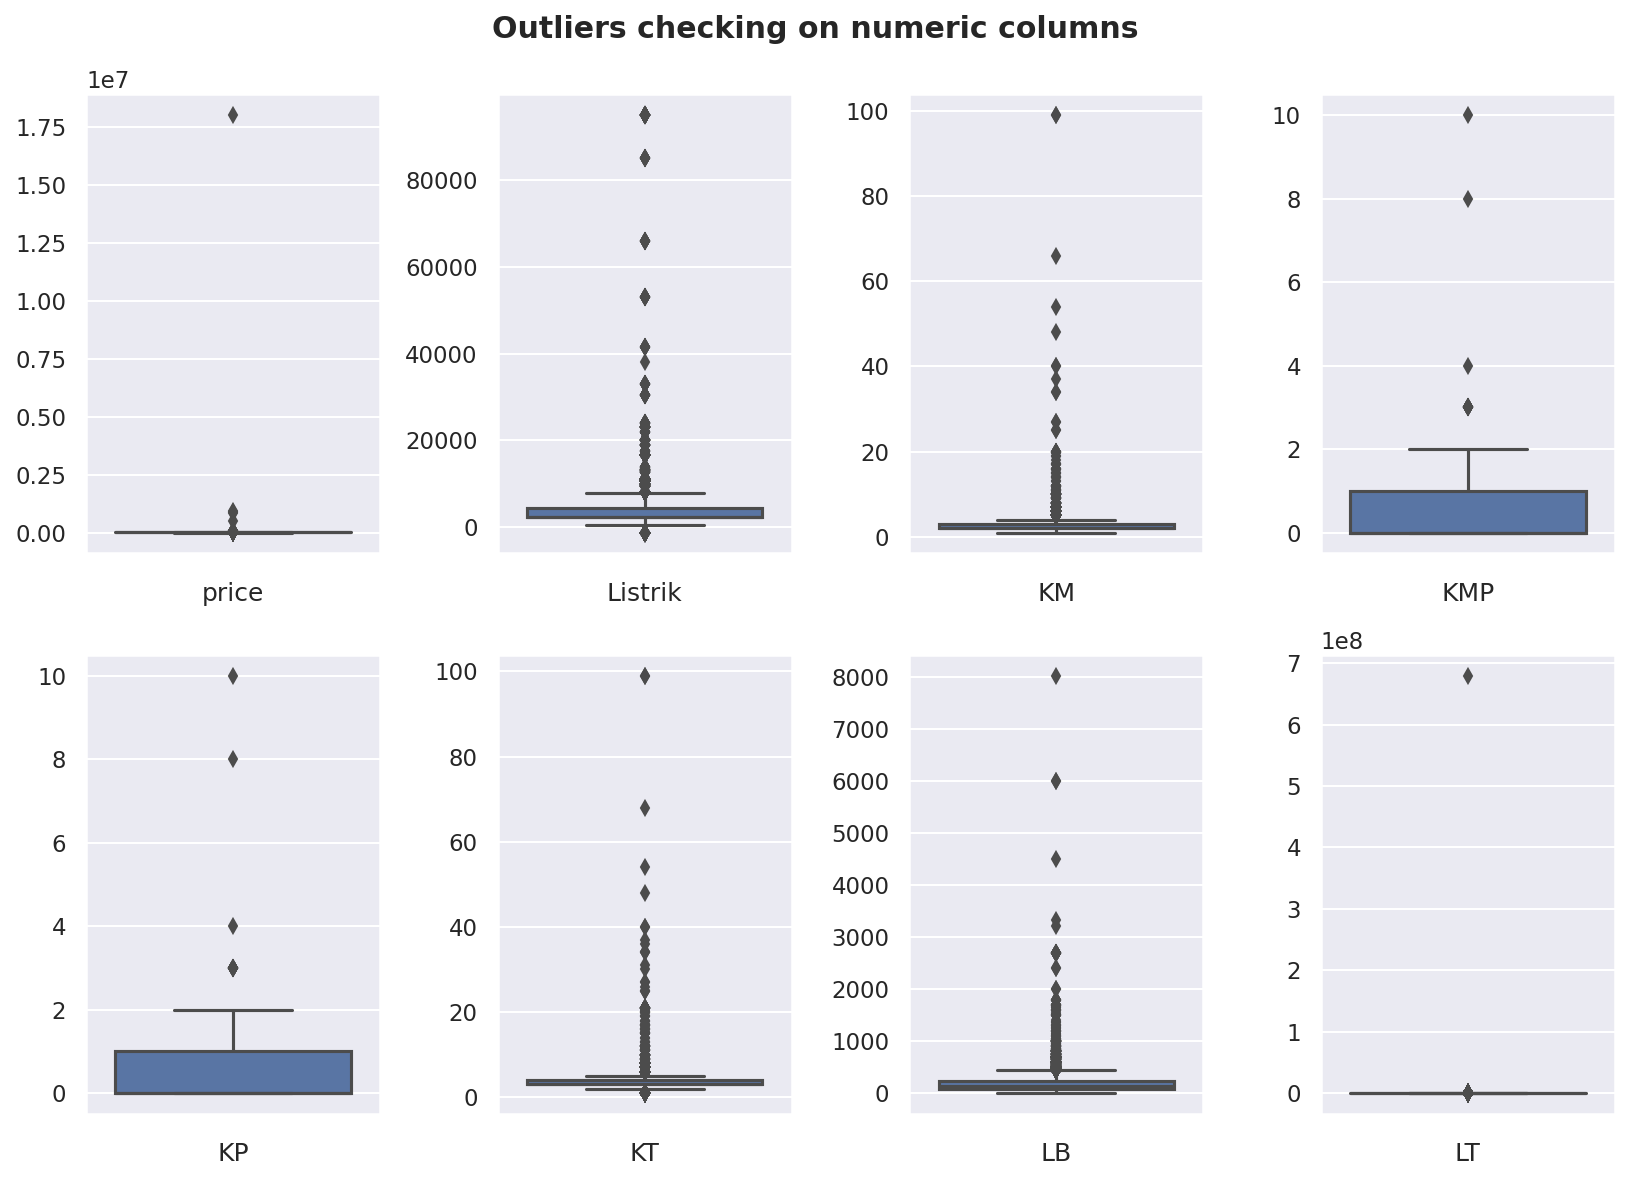

In [42]:
fig, axarr = plt.subplots(2,4, figsize=(11, 8))
for col in dfnum.columns:
    loc = dfnum.columns.get_loc(col)
    y = 0 if loc < 4 else 1
    x = loc if loc < 4 else loc - 4
    sns.boxplot(y = dfnum[col], ax = axarr[y,x])
    axarr[y, x].set_ylabel(None)
    axarr[y, x].set_xlabel(col)
plt.suptitle('Outliers checking on numeric columns', weight='bold')
fig.tight_layout(pad=1)
plt.show()

In [43]:
#removing extreme values
df = df[(df.price < 10000)]
df = df[(df['Listrik'] < 20000)]
df = df[(df['KM'] < 10)]
df = df[(df['KMP'] <= 2)]
df = df[(df['KP'] <= 2)]
df = df[(df['KT'] <= 20)]
df = df[(df['LB'] <= 1000)]
df = df[(df['LT'] <= 1000)]

In [44]:
dfnum = df._get_numeric_data()
dfcat = df.drop(columns = dfnum.columns)

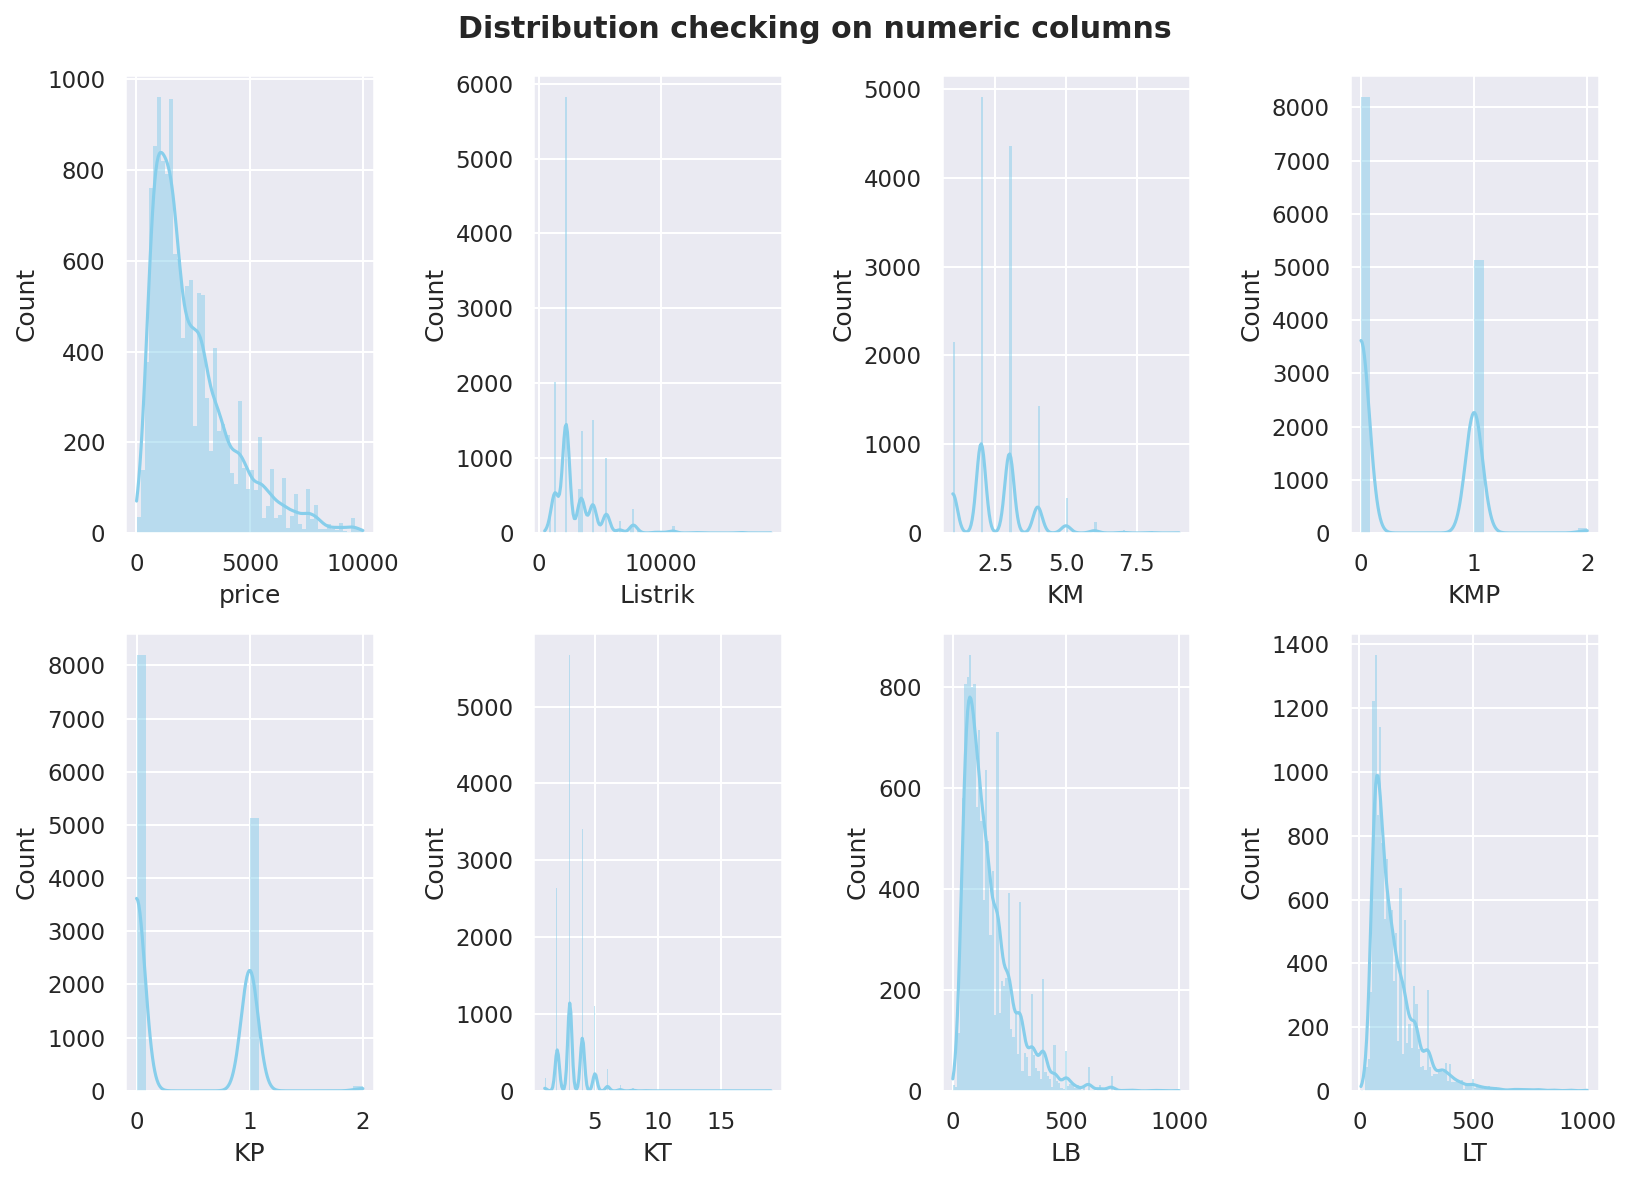

In [45]:
fig, axarr = plt.subplots(2,4, figsize=(11, 8))
for col in dfnum.columns:
    loc = dfnum.columns.get_loc(col)
    y = 0 if loc < 4 else 1
    x = loc if loc < 4 else loc - 4
    sns.histplot(data=dfnum[col], 
                 color='skyblue', 
                 kde=True, 
                 edgecolor='none', 
                 ax=axarr[y, x])
plt.suptitle('Distribution checking on numeric columns', weight='bold')
fig.tight_layout(pad=1)
plt.show()

>We can clearly see that this data is right skewed.

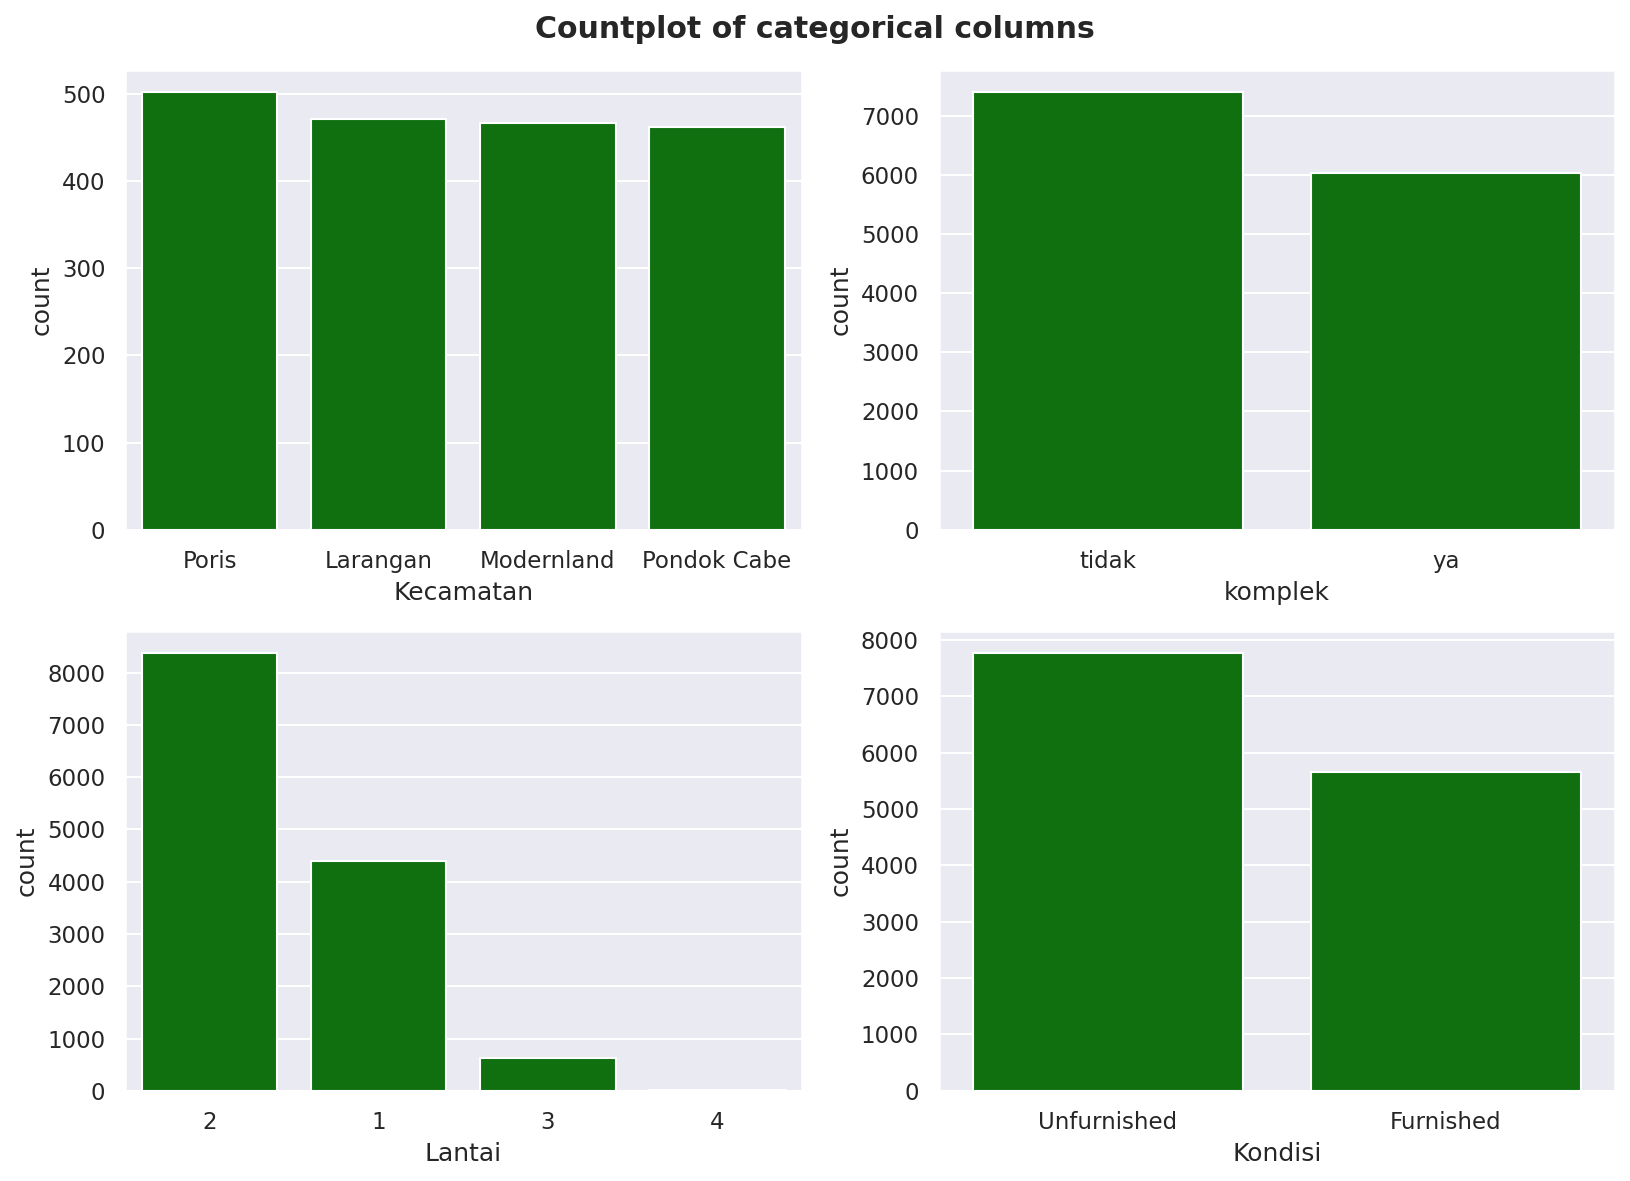

In [46]:
fig, axarr = plt.subplots(2,2, figsize=(11, 8))
for col in dfcat.columns:
    loc = dfcat.columns.get_loc(col)
    y = 0 if loc < 2 else 1
    x = loc if loc < 2 else loc - 2
    sns.countplot(x=df[col], color='green', ax = axarr[y,x], order=df[col].value_counts().iloc[:4].index)

plt.suptitle('Countplot of categorical columns', weight='bold')
fig.tight_layout(pad=1)
plt.show()

### Multivariate Analysis

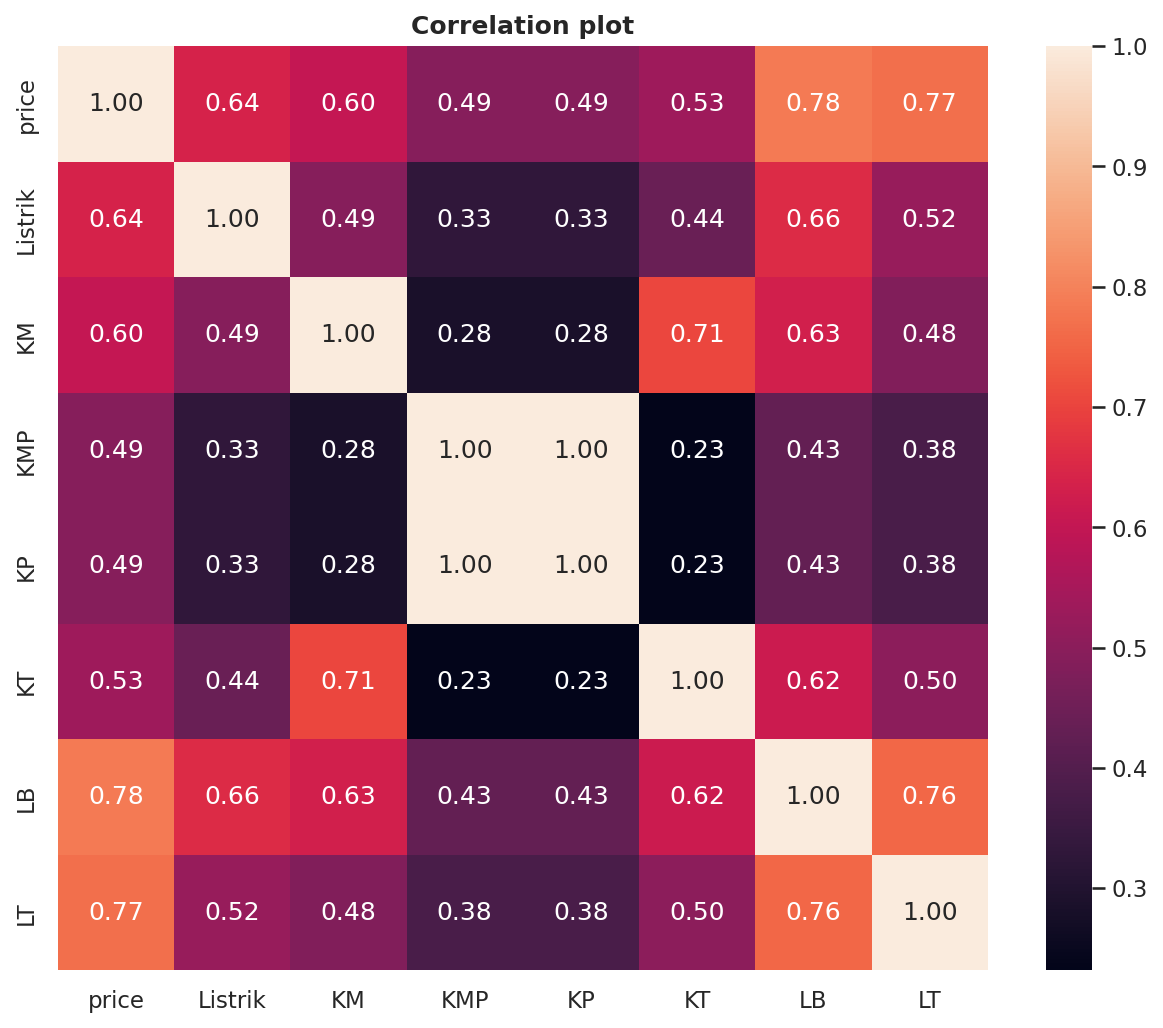

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(dfnum.corr(), annot=True, fmt='.2f')
plt.title('Correlation plot', weight ='bold')
plt.xticks(rotation = 0)
plt.show()

>price, LB, and LT, exhibit a strong positive correlation. Although this correlation is quite strong, it does not lead to multicollinearity issues.

## Deep-Dive Exploratory Data Analysis

In [48]:
df['KMR'] = df.KP + df.KT
df['KMD'] = df.KM + df.KMP
df['Lantai'] = df.Lantai.astype(int)
df['price/m'] = df.price / (df.LT + df.LB)
df.drop(columns=['KM','KMP','KP','KT'], inplace=True)

>I've developed a new feature named 'price/m' by dividing the price by the sum of LT and LB. This feature is more suitable for analysis compared to using just the price alone.

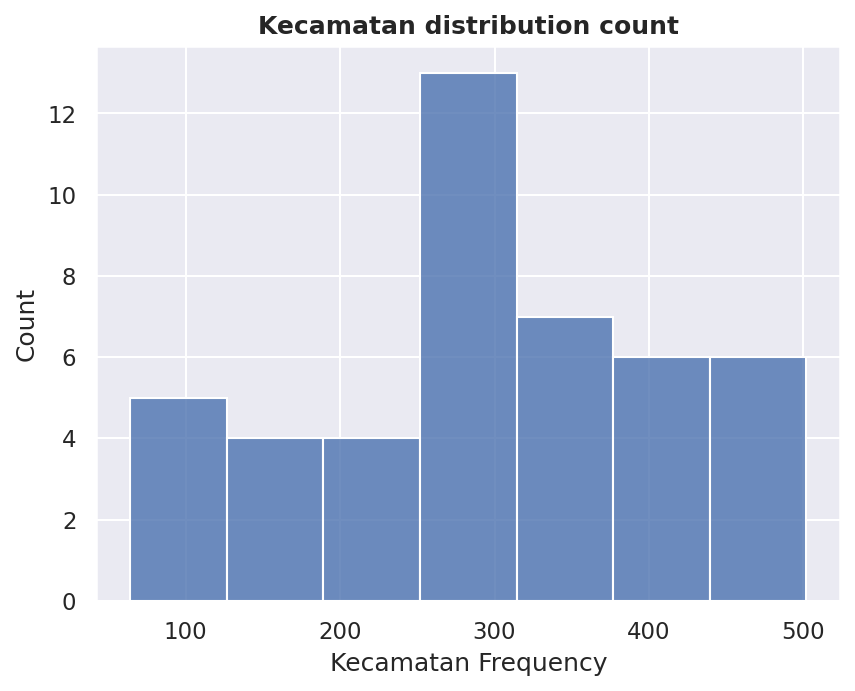

In [49]:
sns.histplot(df.groupby('Kecamatan').size(), alpha=0.8)
plt.xlabel('Kecamatan Frequency')
plt.title('Kecamatan distribution count', weight='bold')
plt.show()

> The plot above illustrates the distribution of samples collected from each Kecamatan. The sample size varies, with the lowest being approximately 100 and the highest reaching 500. In cases of insufficient sample size, potential issues may arise, and further analysis is necessary to determine whether these samples are adequate.

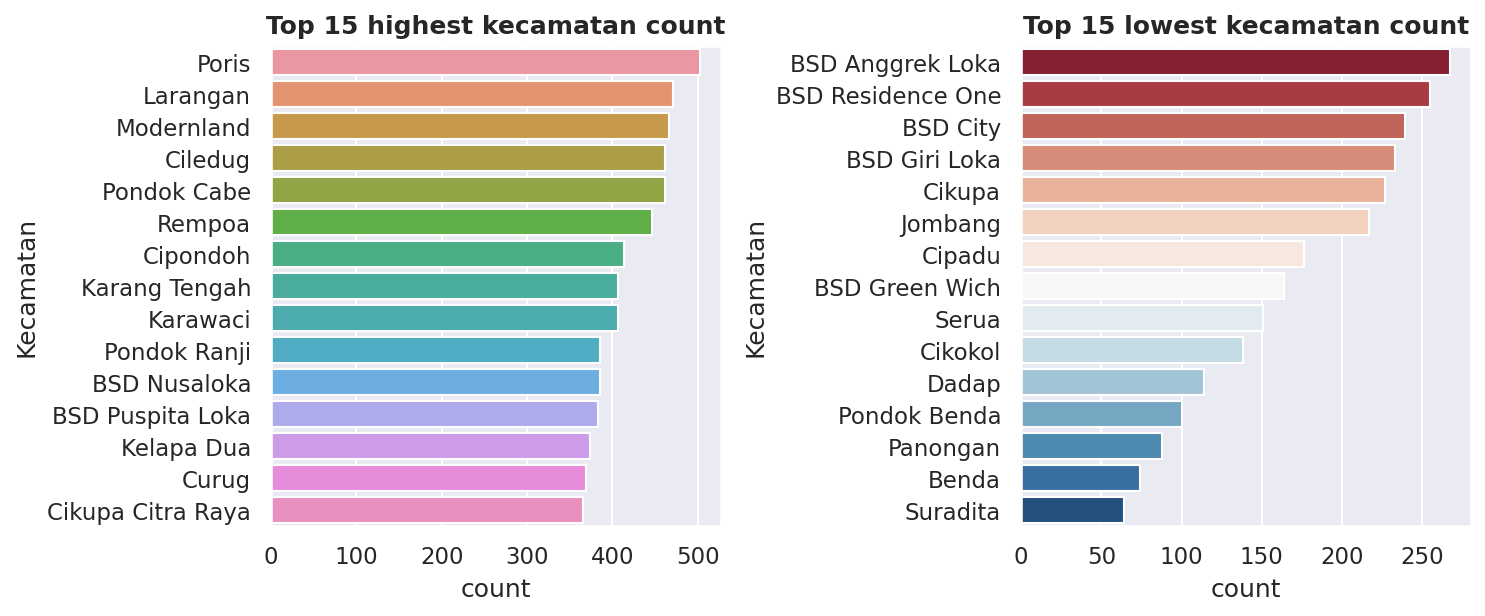

In [50]:
fig, axarr = plt.subplots(1,2, figsize=(10, 4))
data = df.groupby('Kecamatan').size().reset_index(drop=False).sort_values(0, ascending=False)
data.columns = ['Kecamatan','count']
sns.barplot(data = data.head(15), x='count', y='Kecamatan', ax = axarr[0])
sns.barplot(data = data.tail(15), x='count', y='Kecamatan', ax = axarr[1], palette='RdBu')
axarr[0].set_title('Top 15 highest kecamatan count', weight='bold')
axarr[1].set_title('Top 15 lowest kecamatan count', weight='bold')
axarr[0].set_position([0.1, 0.1, 0.3, 0.8])
axarr[1].set_position([0.6, 0.1, 0.3, 0.8])

In [51]:
df['Kecamatan'] = df.Kecamatan.str.replace('Gading Serpong Pondok Hijau Golf' , 'Gading Serpong PHG')

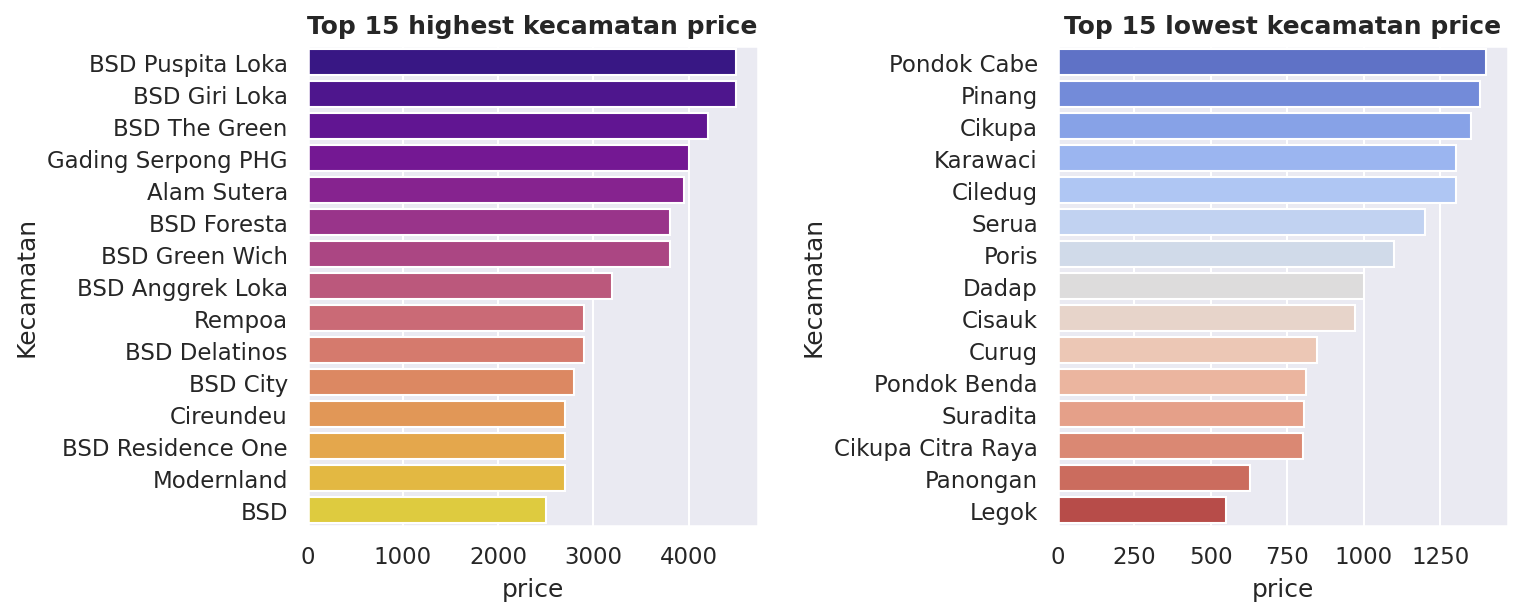

In [52]:
fig, axarr = plt.subplots(1,2, figsize=(10, 4))
data = df.groupby('Kecamatan')[['price']].agg('median').reset_index().sort_values('price', ascending=False)
sns.barplot(data = data.head(15), x='price', y='Kecamatan', ax = axarr[0], palette='plasma')
sns.barplot(data = data.tail(15), x='price', y='Kecamatan', ax = axarr[1], palette='coolwarm')
plt.title('harga per kecamatan')
axarr[0].set_title('Top 15 highest kecamatan price', weight='bold')
axarr[1].set_title('Top 15 lowest kecamatan price', weight='bold')
axarr[0].set_position([0.1, 0.1, 0.3, 0.8])
axarr[1].set_position([0.6, 0.1, 0.3, 0.8])

>BSD is one of the most expensive region in Tangerang

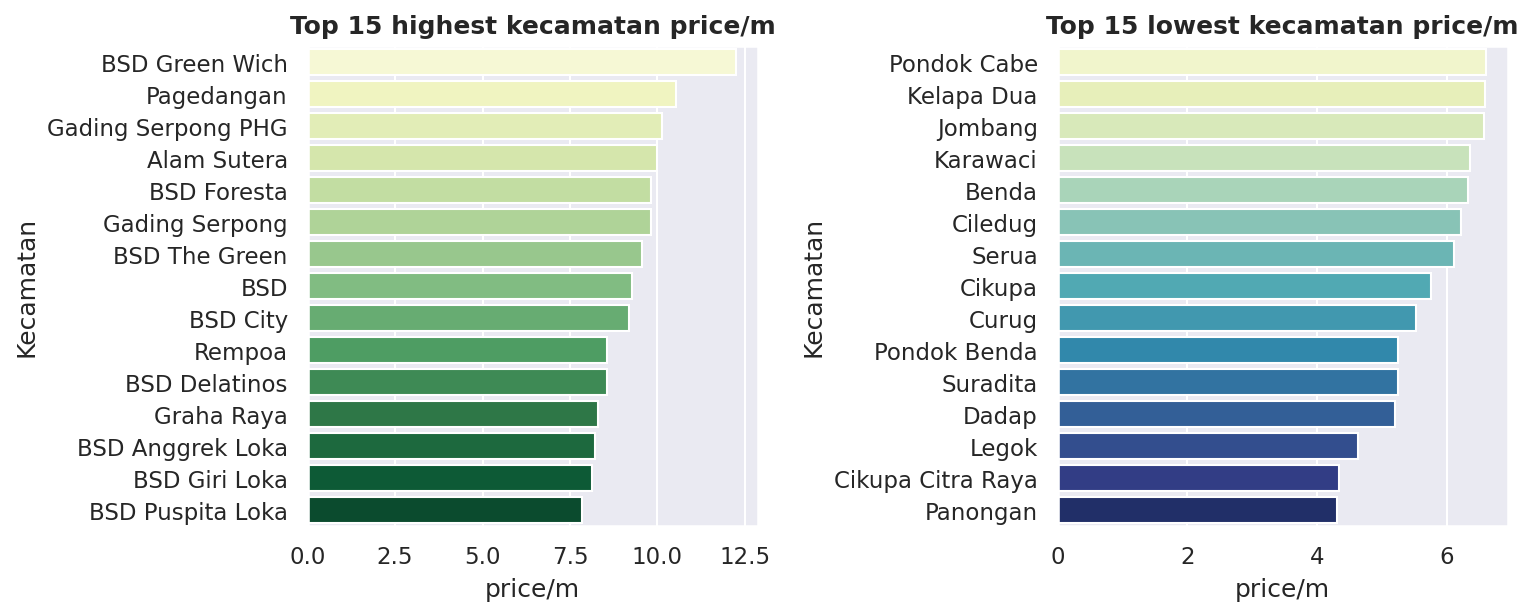

In [53]:
fig, axarr = plt.subplots(1,2, figsize=(10, 4))
data = df.groupby('Kecamatan')[['price/m']].agg('median').reset_index().sort_values('price/m', ascending=False)
sns.barplot(data = data.head(15), x='price/m', y='Kecamatan', ax = axarr[0], palette = 'YlGn')
sns.barplot(data = data.tail(15), x='price/m', y='Kecamatan', ax = axarr[1], palette = 'YlGnBu')
plt.title('harga meteran per kecamatan')
axarr[0].set_title('Top 15 highest kecamatan price/m', weight='bold')
axarr[1].set_title('Top 15 lowest kecamatan price/m', weight='bold')
axarr[0].set_position([0.1, 0.1, 0.3, 0.8])
axarr[1].set_position([0.6, 0.1, 0.3, 0.8])

>from the price/m, bsd is still one of highest price/m

In [54]:
df.Kondisi = df.Kondisi.map(value_mapping)

In [55]:
df['TK'] = df.KMR + df.KMD
df.drop(columns=['KMR','KMD'], inplace=True)

In [56]:
df['avg_price'] = df.groupby(['Kecamatan','Kondisi'])['price/m'].transform('median')

In [57]:
df['rstd'] = df.groupby(['Kecamatan','Kondisi'])['price/m'].transform(lambda x: x.std() * 100 / x.mean())

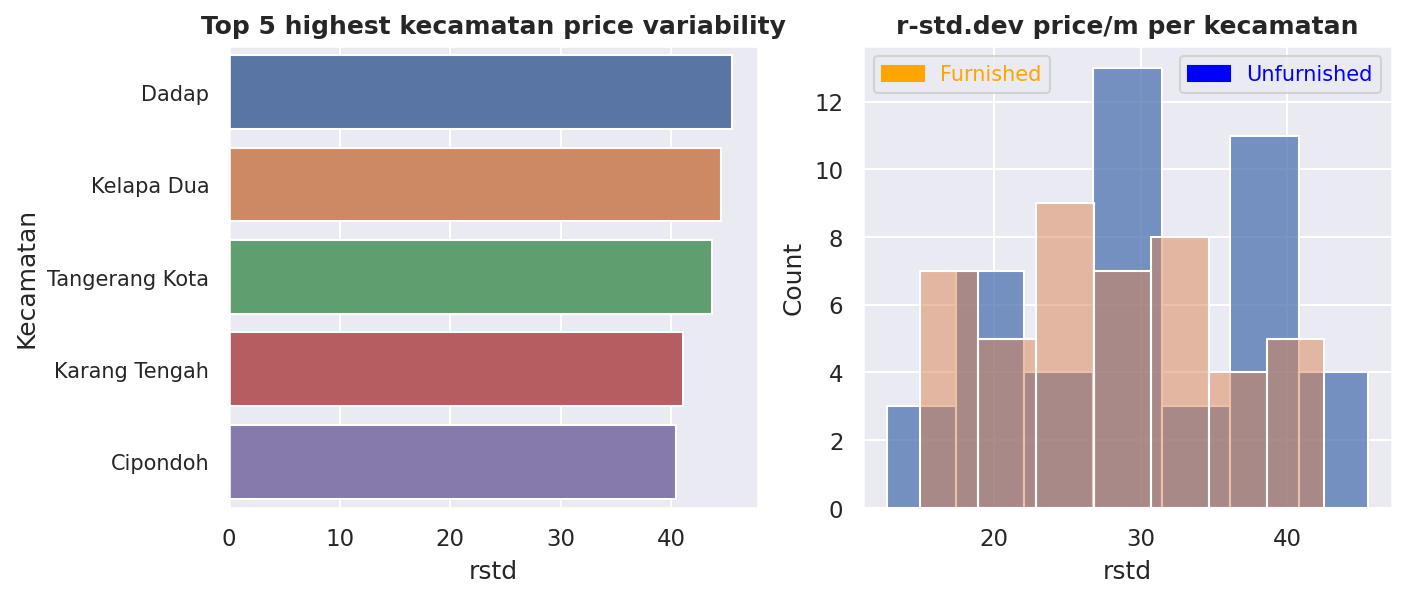

In [58]:
df1 = df[df.Kondisi == 1]
df2 = df[df.Kondisi == 2]

fig, axarr = plt.subplots(1,2, figsize=(10, 4))
data = df1[['Kecamatan','rstd']].drop_duplicates().sort_values('rstd', ascending=False).head()
sns.barplot(data = data, x='rstd', y='Kecamatan', ax = axarr[0])
sns.histplot(data = df1.rstd.drop_duplicates(), ax = axarr[1])
sns.histplot(data = df2.rstd.drop_duplicates(), ax = axarr[1], alpha = 0.5, legend='a')
axarr[0].set_title('Top 5 highest kecamatan price variability', weight='bold')
axarr[1].set_title('r-std.dev price/m per kecamatan', weight='bold')
axarr[0].yaxis.set_tick_params(labelsize=10)

hand2 = [mpatches.Rectangle((0, 0), 1, 1, color='blue', label='Unfurnished')]
hand1 = [mpatches.Rectangle((0, 0), 1, 1, color='orange', label='Furnished')]
legend1 = plt.legend(handles = hand2, loc='upper right', labelcolor='blue')
legend2 = plt.legend(handles = hand1, loc='upper left', labelcolor='orange')
plt.gca().add_artist(legend1)
plt.show()

>R-std, which stands for relative standard deviation, is a valuable tool for assessing variability and making comparisons between datasets. In the displayed plot, we observe that the r-std is distributed within a substantial 30% range. When the price exhibits a high r-std, it typically indicates an insufficient number of samples or a failure to account for critical factors influencing price fluctuations.

In [59]:
#create a variable to contain avg_price information from the data to be used by test data
avg = df[['Kecamatan','Kondisi','avg_price']].drop_duplicates()

In [60]:
#remove anomalies on price that 55% lower or higher than the average price on Kecamatan and Kondisi
df = df[~(df['price/m'] < (df['avg_price'] * 0.55))]
df = df[~(df['price/m'] > (df['avg_price'] * 1.55))]

In [61]:
#remove columns that are no longer needed
df = df.drop(columns=['Kecamatan','price/m','rstd'])

In [62]:
#encoding
df['komplek'] =  df[['komplek']].apply(lambda x: 1 if x.komplek == 'ya' else 0, axis = 1)

In [63]:
#create a variable to contain result from all combination
final_result = pd.DataFrame(index = ['mae','mape','rmse','r2'])

## Modelling Combination 1
For the first combination, I will utilize all available features and apply linear regression.

In [64]:
dfc1 = df.copy().reset_index(drop=True)

In [65]:
dfc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12106 entries, 0 to 12105
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      12106 non-null  int64  
 1   komplek    12106 non-null  int64  
 2   Listrik    12106 non-null  int64  
 3   Lantai     12106 non-null  int64  
 4   Kondisi    12106 non-null  int64  
 5   LB         12106 non-null  int64  
 6   LT         12106 non-null  int64  
 7   TK         12106 non-null  int64  
 8   avg_price  12106 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 851.3 KB


In [66]:
X_train, X_test, y_train, y_test = train_test_split(dfc1.drop(columns='price'), dfc1.price.to_numpy(), test_size = 0.2, random_state=129)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [67]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [68]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [69]:
result = pd.DataFrame()
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

result['test_OLS'] = [mae_test, mape_test, rmse_test, r2_test]
result['train_OLS'] = [mae_train, mape_train, rmse_train, r2_train]
result.index = ['mae','mape','rmse','r2']

In [70]:
result

test_OLS   train_OLS
mae   457.598168  454.727662
mape    0.237016    0.234352
rmse  659.160251  657.519609
r2      0.868921    0.858781

> Above is the result of the base model.

In [71]:
final_result = pd.concat([final_result, result], axis = 1)

## Modelling Combination 2
In this second combination, I intend to enhance model complexity by incorporating polynomial features. If overfitting concerns arise, I will address them by applying ridge regression.

In [72]:
dfc2 = df.copy().reset_index(drop=True) 

In [73]:
dfc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12106 entries, 0 to 12105
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      12106 non-null  int64  
 1   komplek    12106 non-null  int64  
 2   Listrik    12106 non-null  int64  
 3   Lantai     12106 non-null  int64  
 4   Kondisi    12106 non-null  int64  
 5   LB         12106 non-null  int64  
 6   LT         12106 non-null  int64  
 7   TK         12106 non-null  int64  
 8   avg_price  12106 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 851.3 KB


In [74]:
scaler = MinMaxScaler()
df1 = scaler.fit_transform(dfc2.drop(columns=['price']))
df1 = pd.DataFrame(df1, columns = dfc2.drop(columns=['price']).columns)
df1['price'] = dfc2.price
dfc2 = df1.copy()

In [75]:
X_train, X_test, y_train, y_test = train_test_split(dfc2.drop(columns='price'), dfc2.price.to_numpy(), test_size=0.2, random_state=129)

In [76]:
result = pd.DataFrame()
for x in [2,3,4]:
    poly_features = PolynomialFeatures(degree=x)
    X_poly = poly_features.fit_transform(X_train)
    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_train, test_size=0.2, random_state=129)

    model = LinearRegression()
    model.fit(X_train_poly, y_train_poly)

    y_pred_test = model.predict(X_test_poly)
    y_pred_train = model.predict(X_train_poly)

    mae_test = mean_absolute_error(y_test_poly, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test_poly, y_pred_test))
    r2_test = r2_score(y_test_poly, y_pred_test)

    mae_train = mean_absolute_error(y_train_poly, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train_poly, y_pred_train))
    r2_train = r2_score(y_train_poly, y_pred_train)

    result[f'test_{x}'] = [mae_test, rmse_test, r2_test]
    result[f'train_{x}'] = [mae_train, rmse_train, r2_train]

result.index = ['mae','rmse','r2']
result

test_2     train_2      test_3     train_3      test_4     train_4
mae   379.262159  385.261514  377.055129  370.791646  427.898454  352.185058
rmse  572.315609  573.856229  583.278358  544.008417  983.705335  509.210204
r2      0.893668    0.892265    0.889556    0.903181    0.685862    0.915171

>I tested a polynomial degree of 3, and the results indicate a minor degree of overfitting. However, when I increased it to degree 4, the model exhibited a severe overfitting issue.

In [77]:
result = pd.DataFrame()
for x in [3,4]:
    poly_features = PolynomialFeatures(degree=x)
    X_poly = poly_features.fit_transform(X_train)
    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_train, test_size=0.2, random_state=129)

    for alpha in [0.01, 0.1, 1., 10]:
        model = Ridge(alpha=alpha)
        model.fit(X_train_poly, y_train_poly)

        y_pred_test = model.predict(X_test_poly)
        y_pred_train = model.predict(X_train_poly)

        mae_test = mean_absolute_error(y_test_poly, y_pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test_poly, y_pred_test))
        r2_test = r2_score(y_test_poly, y_pred_test)

        mae_train = mean_absolute_error(y_train_poly, y_pred_train)
        rmse_train = np.sqrt(mean_squared_error(y_train_poly, y_pred_train))
        r2_train = r2_score(y_train_poly, y_pred_train)

        result[f'test_{x}_{alpha}'] = [mae_test, rmse_test, r2_test]
        result[f'train_{x}_{alpha}'] = [mae_train, rmse_train, r2_train]

result.index = ['mae','rmse','r2']
result

test_3_0.01  train_3_0.01  test_3_0.1  train_3_0.1  test_3_1.0  \
mae    373.372934    372.576445  373.767775   376.068835  377.911828   
rmse   561.783472    547.690994  561.717546   555.719865  568.664111   
r2       0.897546      0.901865    0.897570     0.898967    0.895021   

      train_3_1.0   test_3_10  train_3_10  test_4_0.01  train_4_0.01  \
mae    383.380417  394.125684  397.669483   375.650853    366.241017   
rmse   569.027031  592.906883  589.258128   579.193753    535.970981   
r2       0.894070    0.885879    0.886404     0.891097      0.906020   

      test_4_0.1  train_4_0.1  test_4_1.0  train_4_1.0   test_4_10  train_4_10  
mae   373.091312   370.823161  375.671070   379.291801  390.296090  394.911108  
rmse  560.770341   546.162490  564.200700   561.655414  583.455739  584.344245  
r2      0.897915     0.902412    0.896662     0.896797    0.889489    0.888291

>I attempted to use ridge regression to tackle overfitting on highly polynomial features, but the outcome wasn't superior to simply using a polynomial degree of 2 without any regularization.

In [78]:
poly_features = PolynomialFeatures(degree=2)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

In [79]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [80]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [81]:
result = pd.DataFrame()
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

result['test_PolyRidgeOLS'] = [mae_test, mape_test, rmse_test, r2_test]
result['train_PolyRidgeOLS'] = [mae_train, mape_train, rmse_train, r2_train]
result.index = ['mae','mape','rmse','r2']

In [82]:
result

test_PolyRidgeOLS  train_PolyRidgeOLS
mae          386.773644          383.694151
mape           0.172408            0.173225
rmse         581.083484          572.616145
r2             0.898134            0.892897

>The model is not overfitting and the result is better than the base model

In [83]:
final_result = pd.concat([final_result, result], axis = 1)

## Modelling Combination 3
Let's try to log transform skewed features and use linear regression.

In [84]:
dfc3 = df.copy().reset_index(drop=True)

In [85]:
column = ['LB','LT','TK']
for col in column:
    dfc3[col] = np.log(dfc3[col])

In [86]:
dfc3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12106 entries, 0 to 12105
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      12106 non-null  int64  
 1   komplek    12106 non-null  int64  
 2   Listrik    12106 non-null  int64  
 3   Lantai     12106 non-null  int64  
 4   Kondisi    12106 non-null  int64  
 5   LB         12106 non-null  float64
 6   LT         12106 non-null  float64
 7   TK         12106 non-null  float64
 8   avg_price  12106 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 851.3 KB


In [87]:
X_train, X_test, y_train, y_test = train_test_split(dfc3.drop(columns='price'), dfc3.price.to_numpy(), test_size = 0.2, random_state=129)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [88]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [89]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [90]:
result = pd.DataFrame()
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

result['test_LogOLS'] = [mae_test, mape_test, rmse_test, r2_test]
result['train_LogOLS'] = [mae_train, mape_train, rmse_train, r2_train]
result.index = ['mae','mape','rmse','r2']

In [91]:
result

test_LogOLS  train_LogOLS
mae    532.349756    528.405836
mape     0.313665      0.309628
rmse   742.331745    728.151838
r2       0.833756      0.826812

>The results show a performance decline compared to using Linear Regression on the original, untransformed features.

In [92]:
final_result = pd.concat([final_result, result], axis = 1)

## Modelling Combination 4
For this combination, let's try XGBRegressor 

In [93]:
dfc4 = df.copy()

In [94]:
dfc4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12106 entries, 0 to 17049
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      12106 non-null  int64  
 1   komplek    12106 non-null  int64  
 2   Listrik    12106 non-null  int64  
 3   Lantai     12106 non-null  int64  
 4   Kondisi    12106 non-null  int64  
 5   LB         12106 non-null  int64  
 6   LT         12106 non-null  int64  
 7   TK         12106 non-null  int64  
 8   avg_price  12106 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 945.8 KB


In [95]:
X_train, X_test, y_train, y_test = train_test_split(dfc4.drop(columns='price'), dfc4.price.to_numpy(), test_size = 0.2, random_state=129)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [96]:
xgb_regressor = XGBRegressor(
    objective='reg:squarederror',  
    eval_metric='rmse',           
    random_state=42               
)

In [97]:
param_grid = {  
    'learning_rate': [0.001, 0.01],  
    'n_estimators': [100, 400, 900, 1000],  
    'max_depth': [3, 4],  
    'eval_metric': ['rmse'],  
}


In [98]:
grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,                              
    verbose=1,                         
    n_jobs=-1                           
)


In [99]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/vertikal/data_science/exploration/houses-explore/.venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/vertikal/data_science/exploration/houses-explore/.venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/vertikal/data_science/exploration/houses-explore/.venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/vertikal/data_science/exploration/houses-explore/.venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated an

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['rmse'],
                         'learning_rate': [0.001, 0.01], 'max_depth': [3, 4],
                         'n_estimators': [100, 400, 900, 1000]},
             scoring='neg_mean_squared_error', verbose=1)

In [100]:
best_params_xgb = grid_search.best_params_

In [101]:
best_params_xgb

{'eval_metric': 'rmse',
 'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 1000}

In [102]:
xgboost = XGBRegressor(**best_params_xgb, random_state=42)

In [103]:
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [104]:
y_pred_test = xgboost.predict(X_test)
y_pred_train = xgboost.predict(X_train)

In [105]:
result = pd.DataFrame()
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

result['test_XGB'] = [mae_test, mape_test, rmse_test, r2_test]
result['train_XGB'] = [mae_train, mape_train, rmse_train, r2_train]
result.index = ['mae','mape','rmse','r2']

In [106]:
result

test_XGB   train_XGB
mae   359.456740  339.244084
mape    0.163079    0.158518
rmse  535.128940  492.049092
r2      0.913609    0.920916

>The model is little overfit. But this is the best model so far

In [107]:
final_result = pd.concat([final_result, result], axis = 1)

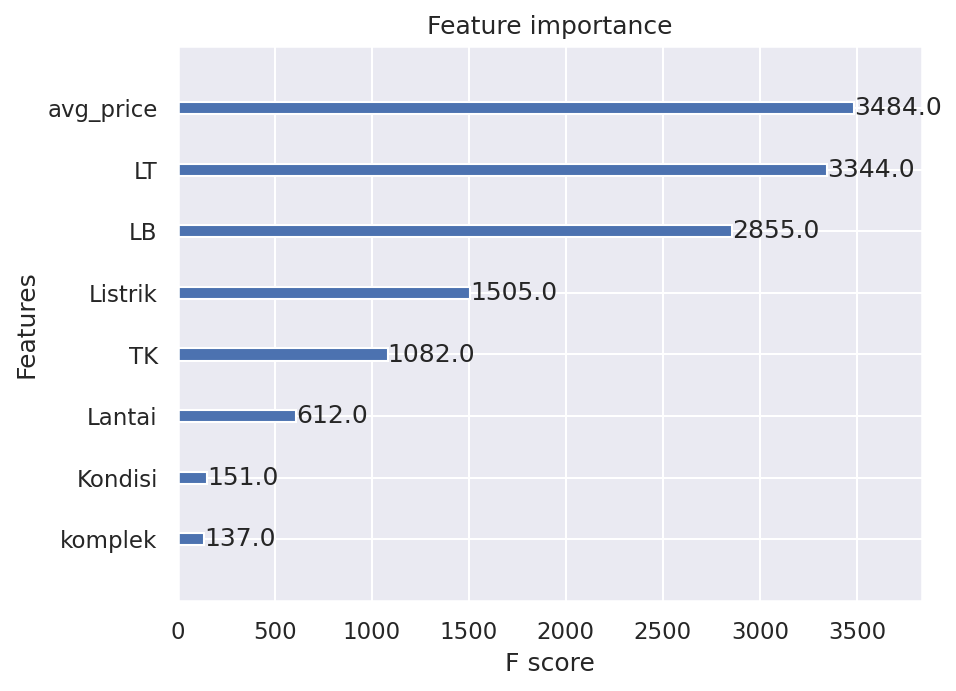

In [108]:
xgb.plot_importance(xgboost)  # You can also use 'gain' or 'cover' for importance_type
plt.show()

## Modelling Combination 5
I will use RandomForest on this combination. But using RandomForest model on this case is very computational expensive because of many continuous features. 

In [109]:
dfc5 = df.copy().reset_index(drop=True) #df[['LT','avg_price','distance','LB','Listrik','price']]

In [110]:
dfc5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12106 entries, 0 to 12105
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      12106 non-null  int64  
 1   komplek    12106 non-null  int64  
 2   Listrik    12106 non-null  int64  
 3   Lantai     12106 non-null  int64  
 4   Kondisi    12106 non-null  int64  
 5   LB         12106 non-null  int64  
 6   LT         12106 non-null  int64  
 7   TK         12106 non-null  int64  
 8   avg_price  12106 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 851.3 KB


In [111]:
X_train, X_test, y_train, y_test = train_test_split(dfc5.drop(columns='price'), dfc5.price.to_numpy(), test_size = 0.2, random_state=129)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [112]:
randomforest = RandomForestRegressor(random_state=42)

In [113]:
param_grid = {
    'n_estimators': [600],
    'max_depth': [8, 7],
    'min_samples_split': [10, 50, 100],
}

In [114]:
grid_search = GridSearchCV(estimator=randomforest, param_grid=param_grid, cv=5, n_jobs=-1)

In [115]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8, 7],
                         'min_samples_split': [10, 50, 100],
                         'n_estimators': [600]})

In [116]:
best_params_rf = grid_search.best_params_

In [117]:
best_params_rf

{'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 600}

In [118]:
rf = RandomForestRegressor(**best_params_rf, random_state=42)

In [119]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=10, n_estimators=600,
                      random_state=42)

In [120]:
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

In [121]:
result = pd.DataFrame()
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

result['test_RF'] = [mae_test, mape_test, rmse_test, r2_test]
result['train_RF'] = [mae_train, mape_train, rmse_train, r2_train]
result.index = ['mae','mape','rmse','r2']

In [122]:
result

test_RF    train_RF
mae   360.607435  316.203144
mape    0.164837    0.151192
rmse  542.694955  463.391621
r2      0.911149    0.929859

>The result is more or less the same with XGBoost model.

In [123]:
final_result = pd.concat([final_result, result], axis = 1)

## Modelling Combination 6
For this last combination, let's see how AdaBoost perform.

In [124]:
dfc6 = df.copy().reset_index(drop=True) #df[['LT','avg_price','distance','LB','Listrik','price']]

In [125]:
dfc6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12106 entries, 0 to 12105
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      12106 non-null  int64  
 1   komplek    12106 non-null  int64  
 2   Listrik    12106 non-null  int64  
 3   Lantai     12106 non-null  int64  
 4   Kondisi    12106 non-null  int64  
 5   LB         12106 non-null  int64  
 6   LT         12106 non-null  int64  
 7   TK         12106 non-null  int64  
 8   avg_price  12106 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 851.3 KB


In [126]:
X_train, X_test, y_train, y_test = train_test_split(dfc5.drop(columns='price'), dfc5.price.to_numpy(), test_size = 0.2, random_state=129)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [127]:
adaboost = AdaBoostRegressor(random_state = 42)

In [128]:
param_grid = {
    'n_estimators': [50, 150, 250],
    'learning_rate': [0.01, 0.1, 1, 0.001]
}

In [129]:
grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, n_jobs=-1)

In [130]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 0.001],
                         'n_estimators': [50, 150, 250]})

In [131]:
best_params_ada = grid_search.best_params_

In [132]:
best_params_ada

{'learning_rate': 0.1, 'n_estimators': 150}

In [133]:
ada = AdaBoostRegressor(**best_params_ada, random_state=42)

In [134]:
ada.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.1, n_estimators=150, random_state=42)

In [135]:
y_pred_test = ada.predict(X_test)
y_pred_train = ada.predict(X_train)

In [136]:
result = pd.DataFrame()
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

result['test_ADA'] = [mae_test, mape_test, rmse_test, r2_test]
result['train_ADA'] = [mae_train, mape_train, rmse_train, r2_train]
result.index = ['mae','mape','rmse','r2']

In [137]:
result

test_ADA   train_ADA
mae   493.062994  490.048969
mape    0.297900    0.296926
rmse  667.310542  663.486410
r2      0.865660    0.856207

In [138]:
final_result = pd.concat([final_result, result], axis = 1)

## Choosing The Best Combination
Let's use the best combination

In [139]:
final_result

test_OLS   train_OLS  test_PolyRidgeOLS  train_PolyRidgeOLS  \
mae   457.598168  454.727662         386.773644          383.694151   
mape    0.237016    0.234352           0.172408            0.173225   
rmse  659.160251  657.519609         581.083484          572.616145   
r2      0.868921    0.858781           0.898134            0.892897   

      test_LogOLS  train_LogOLS    test_XGB   train_XGB     test_RF  \
mae    532.349756    528.405836  359.456740  339.244084  360.607435   
mape     0.313665      0.309628    0.163079    0.158518    0.164837   
rmse   742.331745    728.151838  535.128940  492.049092  542.694955   
r2       0.833756      0.826812    0.913609    0.920916    0.911149   

        train_RF    test_ADA   train_ADA  
mae   316.203144  493.062994  490.048969  
mape    0.151192    0.297900    0.296926  
rmse  463.391621  667.310542  663.486410  
r2      0.929859    0.865660    0.856207

>By seeing the results, 2 best models are XGBoost and RandomForrest. I'll go with XGBoost because it way more less computational than RandomForest

In [140]:
#choosing only the most important features for XGB
df = df[['LT','avg_price','LB','price','Listrik']]

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'), df.price.to_numpy(), test_size = 0.2, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [141]:
#Activate the code below to use avg_price only from the training data.

#df = df[['LT','avg_price','LB','price','Listrik']]

#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'), df.price.to_numpy(), test_size = 0.2, random_state=123)
#X_train = X_train.reset_index(drop=True)
#X_test = X_test.reset_index(drop=True)

#X_train['avg'] = X_train.groupby(['Kecamatan','Kondisi'])['price/m'].transform('median')
#avg = X_train[['Kecamatan','Kondisi','avg']].drop_duplicates()
#X_train.drop(columns = ['Kecamatan','Kondisi','price/m'], inplace = True)
#X_test = pd.merge(X_test, avg , on=['Kecamatan','Kondisi'], how='left').convert_dtypes()
#X_test.drop(columns = ['Kecamatan','Kondisi','price/m'], inplace = True)

In [142]:
best_xgb_regressor = XGBRegressor(**best_params_xgb, random_state=42)

In [143]:
best_xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [144]:
y_pred_test = best_xgb_regressor.predict(X_test)
y_pred_train = best_xgb_regressor.predict(X_train)

In [145]:
result = pd.DataFrame()
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

result['test_XGB'] = [mae_test, mape_test, rmse_test, r2_test]
result['train_XGB'] = [mae_train, mape_train, rmse_train, r2_train]
result.index = ['mae','mape','rmse','r2']

In [146]:
result

test_XGB   train_XGB
mae   357.625297  345.181820
mape    0.165441    0.162178
rmse  529.811255  500.621865
r2      0.907478    0.919963

> The results remain favorable and consistent

## Model Evaluation & Interpretation
Here, I will assess and interpret the model's performance using a new set of sample data that I collected separately from the main dataset.

In [147]:
test = pd.read_csv('test.csv')
test = pd.merge(test, avg , on=['Kecamatan','Kondisi']).convert_dtypes()

>Add the avg_price column to test data.

In [148]:
test = test[(test.price < 10000) & (test.price > 100)]
test = test[test.LB < 900]
test = test[test.LT < 500]
test = test[['LT','avg_price','LB','Listrik','price']]

> Clean the test data

In [149]:
test_x = test[['LT','avg_price','LB','Listrik']]
test_y = test.price

In [150]:
y_pred_test = best_xgb_regressor.predict(test_x)
y_test = test_y

In [151]:
result = pd.DataFrame()
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

result['test_XGB'] = [mae_test, mape_test, rmse_test, r2_test]
result['train_XGB'] = [mae_train, mape_train, rmse_train, r2_train]
result.index = ['mae','mape','rmse','r2']

In [152]:
result

test_XGB   train_XGB
mae   544.067733  345.181820
mape    0.218998    0.162178
rmse  909.390809  500.621865
r2      0.773360    0.919963

>The model perform worse on scrapped test data.

### Residuals Plot

In [153]:
res = pd.DataFrame([list(y_test), list(y_pred_test)]).transpose()
res.columns = ['test','pred']
res['residual'] = res.test - res.pred
res['residualp'] = abs(res.test - res.pred) * 100 / res.test

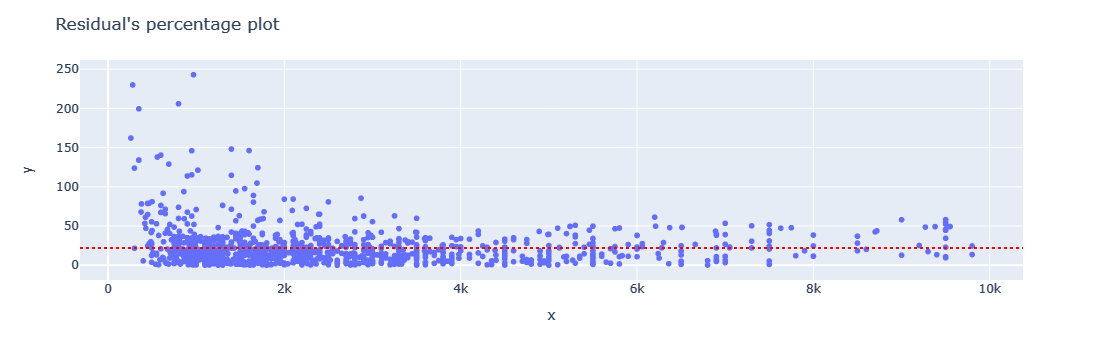

In [154]:
fig = px.scatter(x=res['test'], y=res['residualp'])
fig.update_layout( 
    height = 700,
    title = 'Residual\'s percentage plot'
)
fig.add_hline(y=res['residualp'].mean(), line_dash="dot", line_color="red")
fig

>From the residual percentage above we can see that :<br>
>1. 7.5% of data is APE that is more than 50%.<br>
>2. 59% of data is APE that is lower than 20%.<br>
>3. 32.5% of data is ape that is 20% - 50%.<br>
>4. When the houses prices is 4 million, the model become worse as the price kept going up.<br>
>5. There are extreme APE error on 0 to 2k prices, this indicate that there are anomalies data inserted.

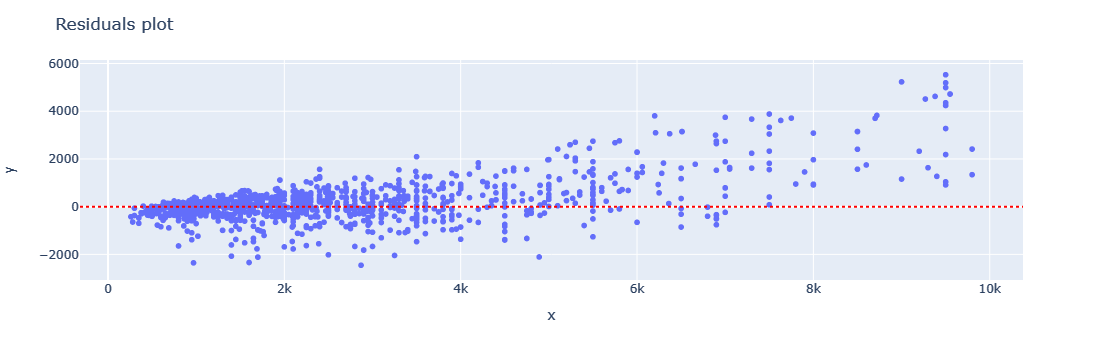

In [155]:
fig = px.scatter(x=res['test'], y=res['residual'])
fig.update_layout(  
    height = 700,
    title = 'Residuals plot'
)
fig.add_hline(y=0, line_dash="dot", line_color="red")
fig

> The unequal variance in the data implies the presence of heteroscedasticity, and a higher price is associated with increased variability. This phenomenon is considered normal since more expensive houses involve a greater number of factors in determining their prices. Additionally, the model also consistently underpredicts as house prices increase. I think we need to gather more variables or predictors that influence house prices.

### PDP & ICE Plots

In [156]:
def pdp_ice_plot(model, df_test, column, clusters=True):
    df_test = df_test.copy()
    pdp_isolate = pdp.PDPIsolate(model = model, df = df_test, 
                      num_grid_points=20,
                      model_features = df_test.columns, 
                      feature = column, feature_name=column, n_classes=0)
    pdp_isolate.plot(
                center=True, plot_lines=True,
                cluster=clusters, n_cluster_centers=5,cluster_method='accurate',
                plot_pts_dist=False, to_bins=True,
                show_percentile=False, which_classes=None,
                figsize=(10,6), dpi=300,
                ncols=2, plot_params={"pdp_hl": True},
                engine='matplotlib', template='plotly_white')
    
    plt.show()
    return pdp_isolate

obtain pred_func from the provided model.


  0%|          | 0/20 [00:00<?, ?it/s]

findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


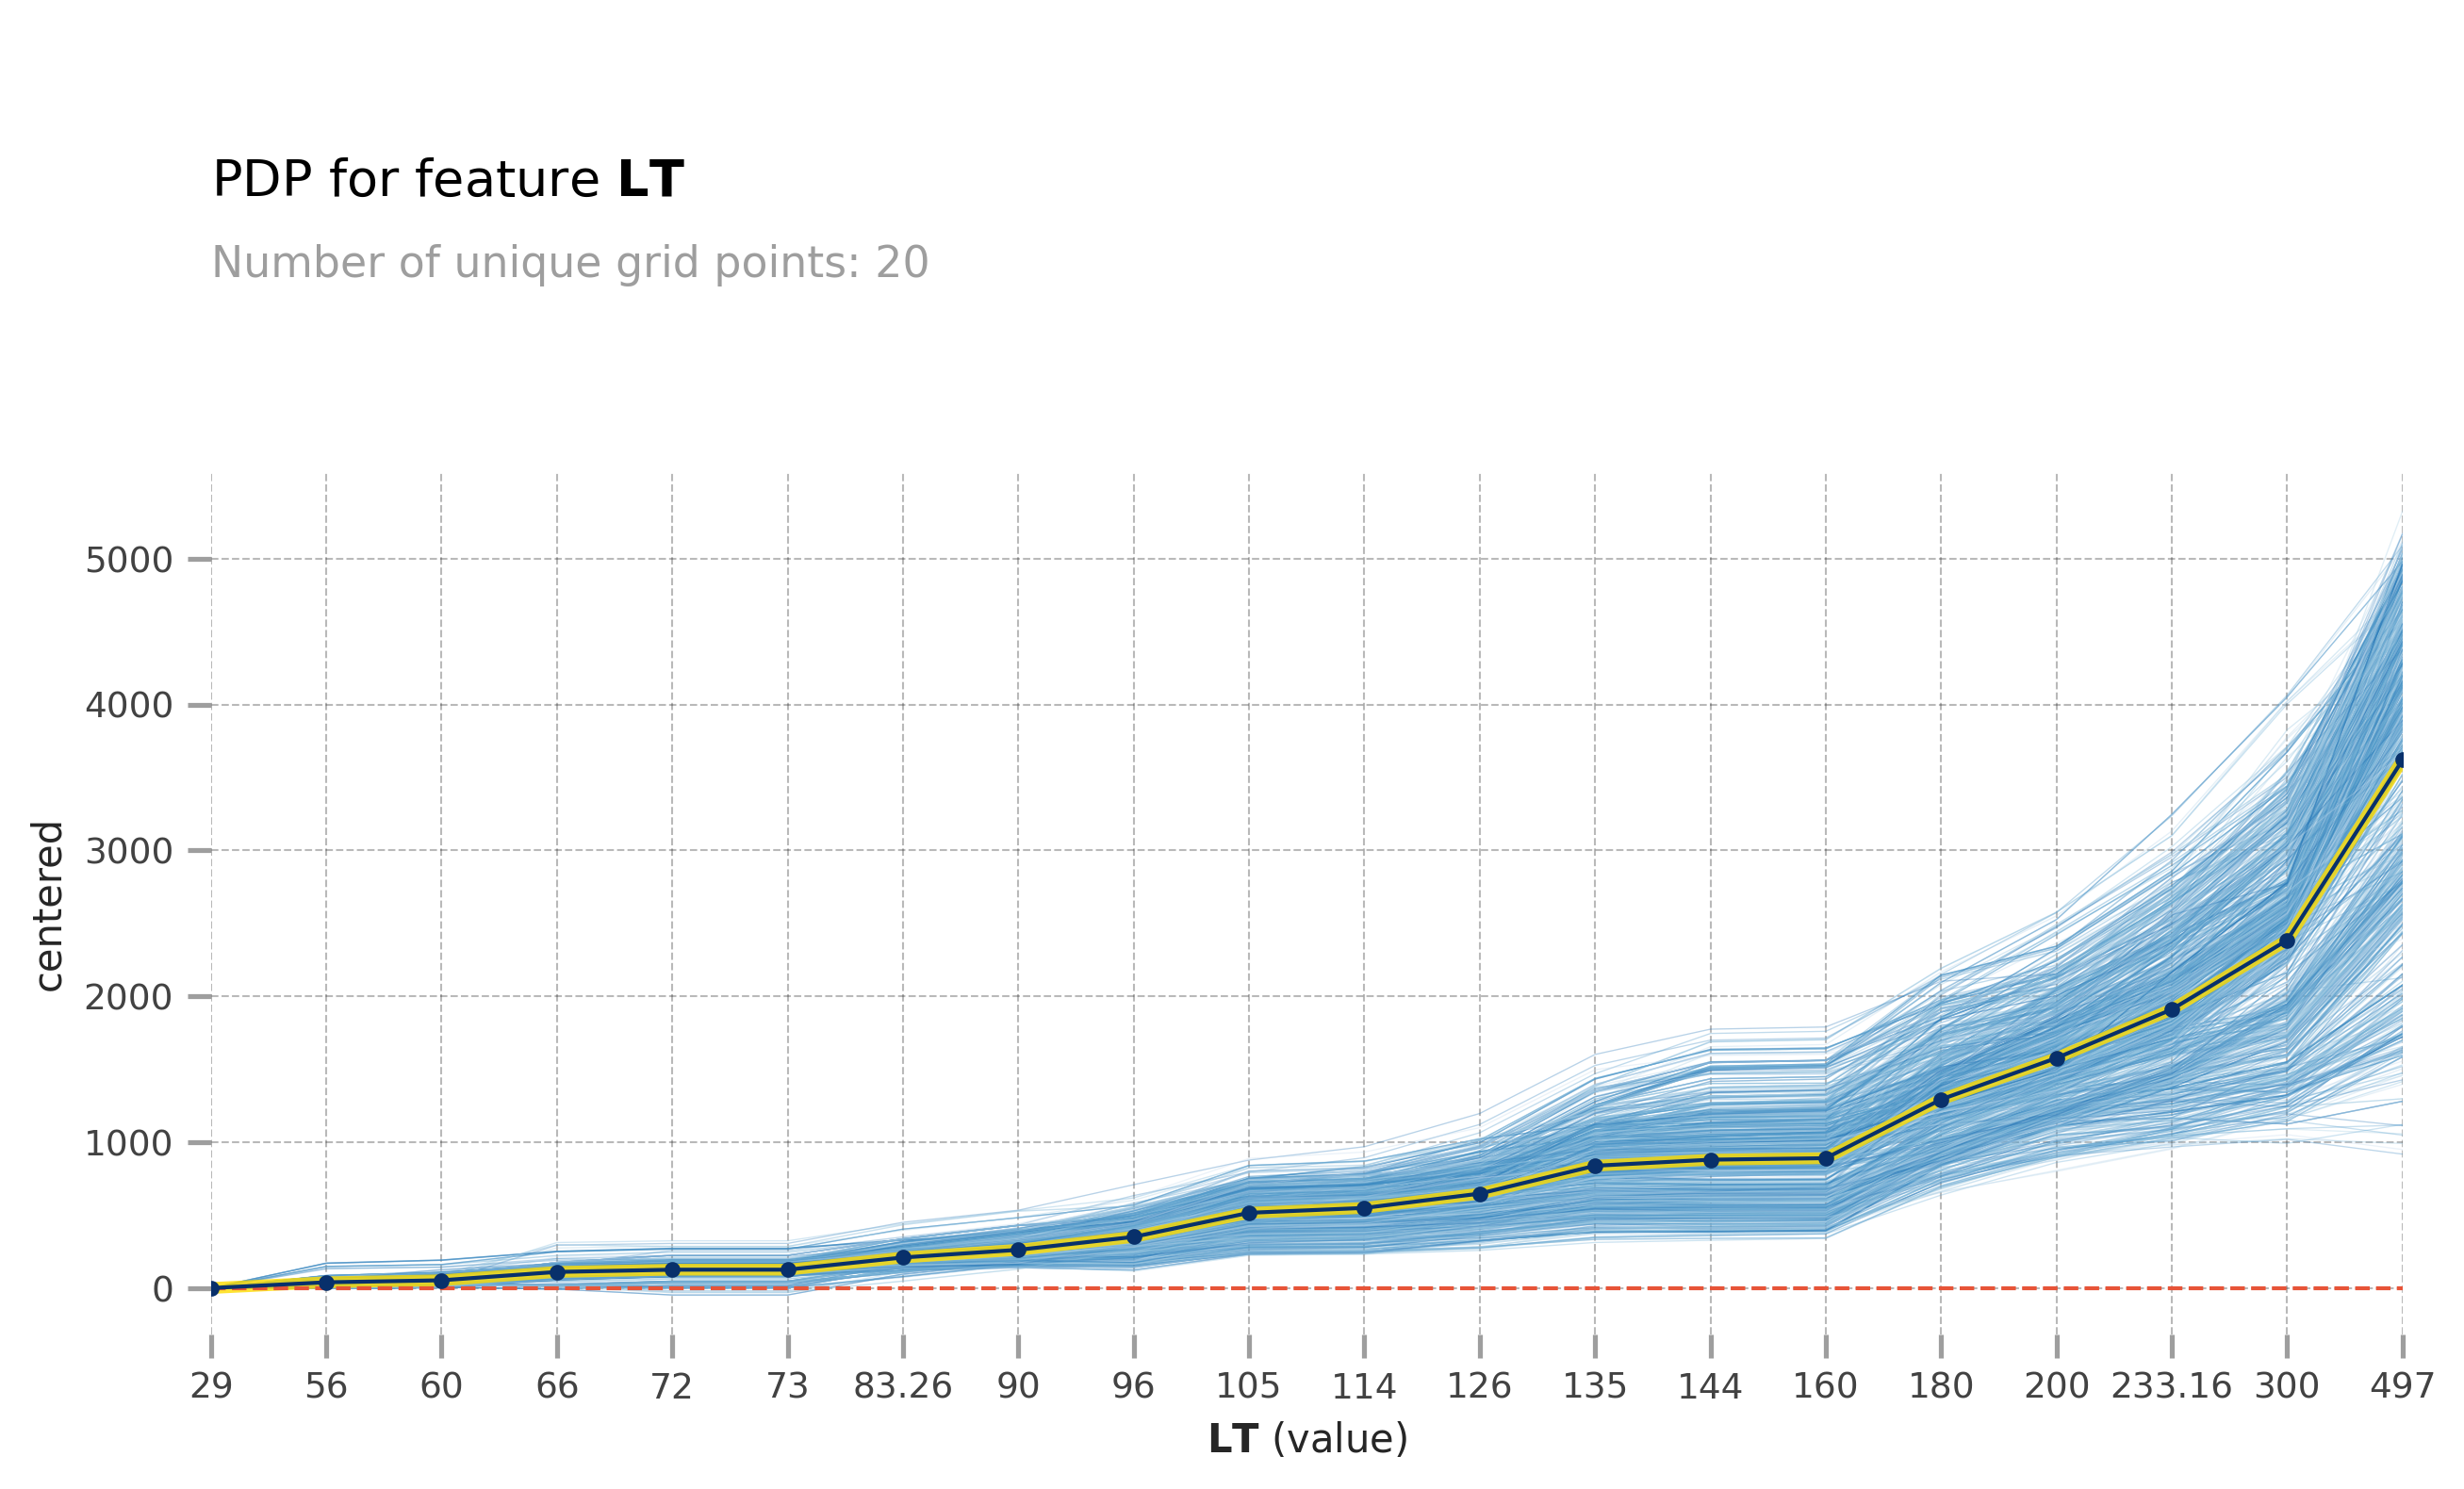

In [157]:
pdp_ice_plot(best_xgb_regressor, test_x, 'LT', clusters=False)

>The Larger the LT, higher the price. But as the LT get higher, the price is also more disperse.

In [158]:
test1 = test_x.copy()
pdp_interact = pdp.PDPInteract(model=best_xgb_regressor, df=test1,
                              num_grid_points=10,
                              model_features = test1.columns, 
                              features=['LB','avg_price'], 
                              feature_names=['LB','avg_price'], n_classes=0)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/100 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/18 [00:00<?, ?it/s]

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


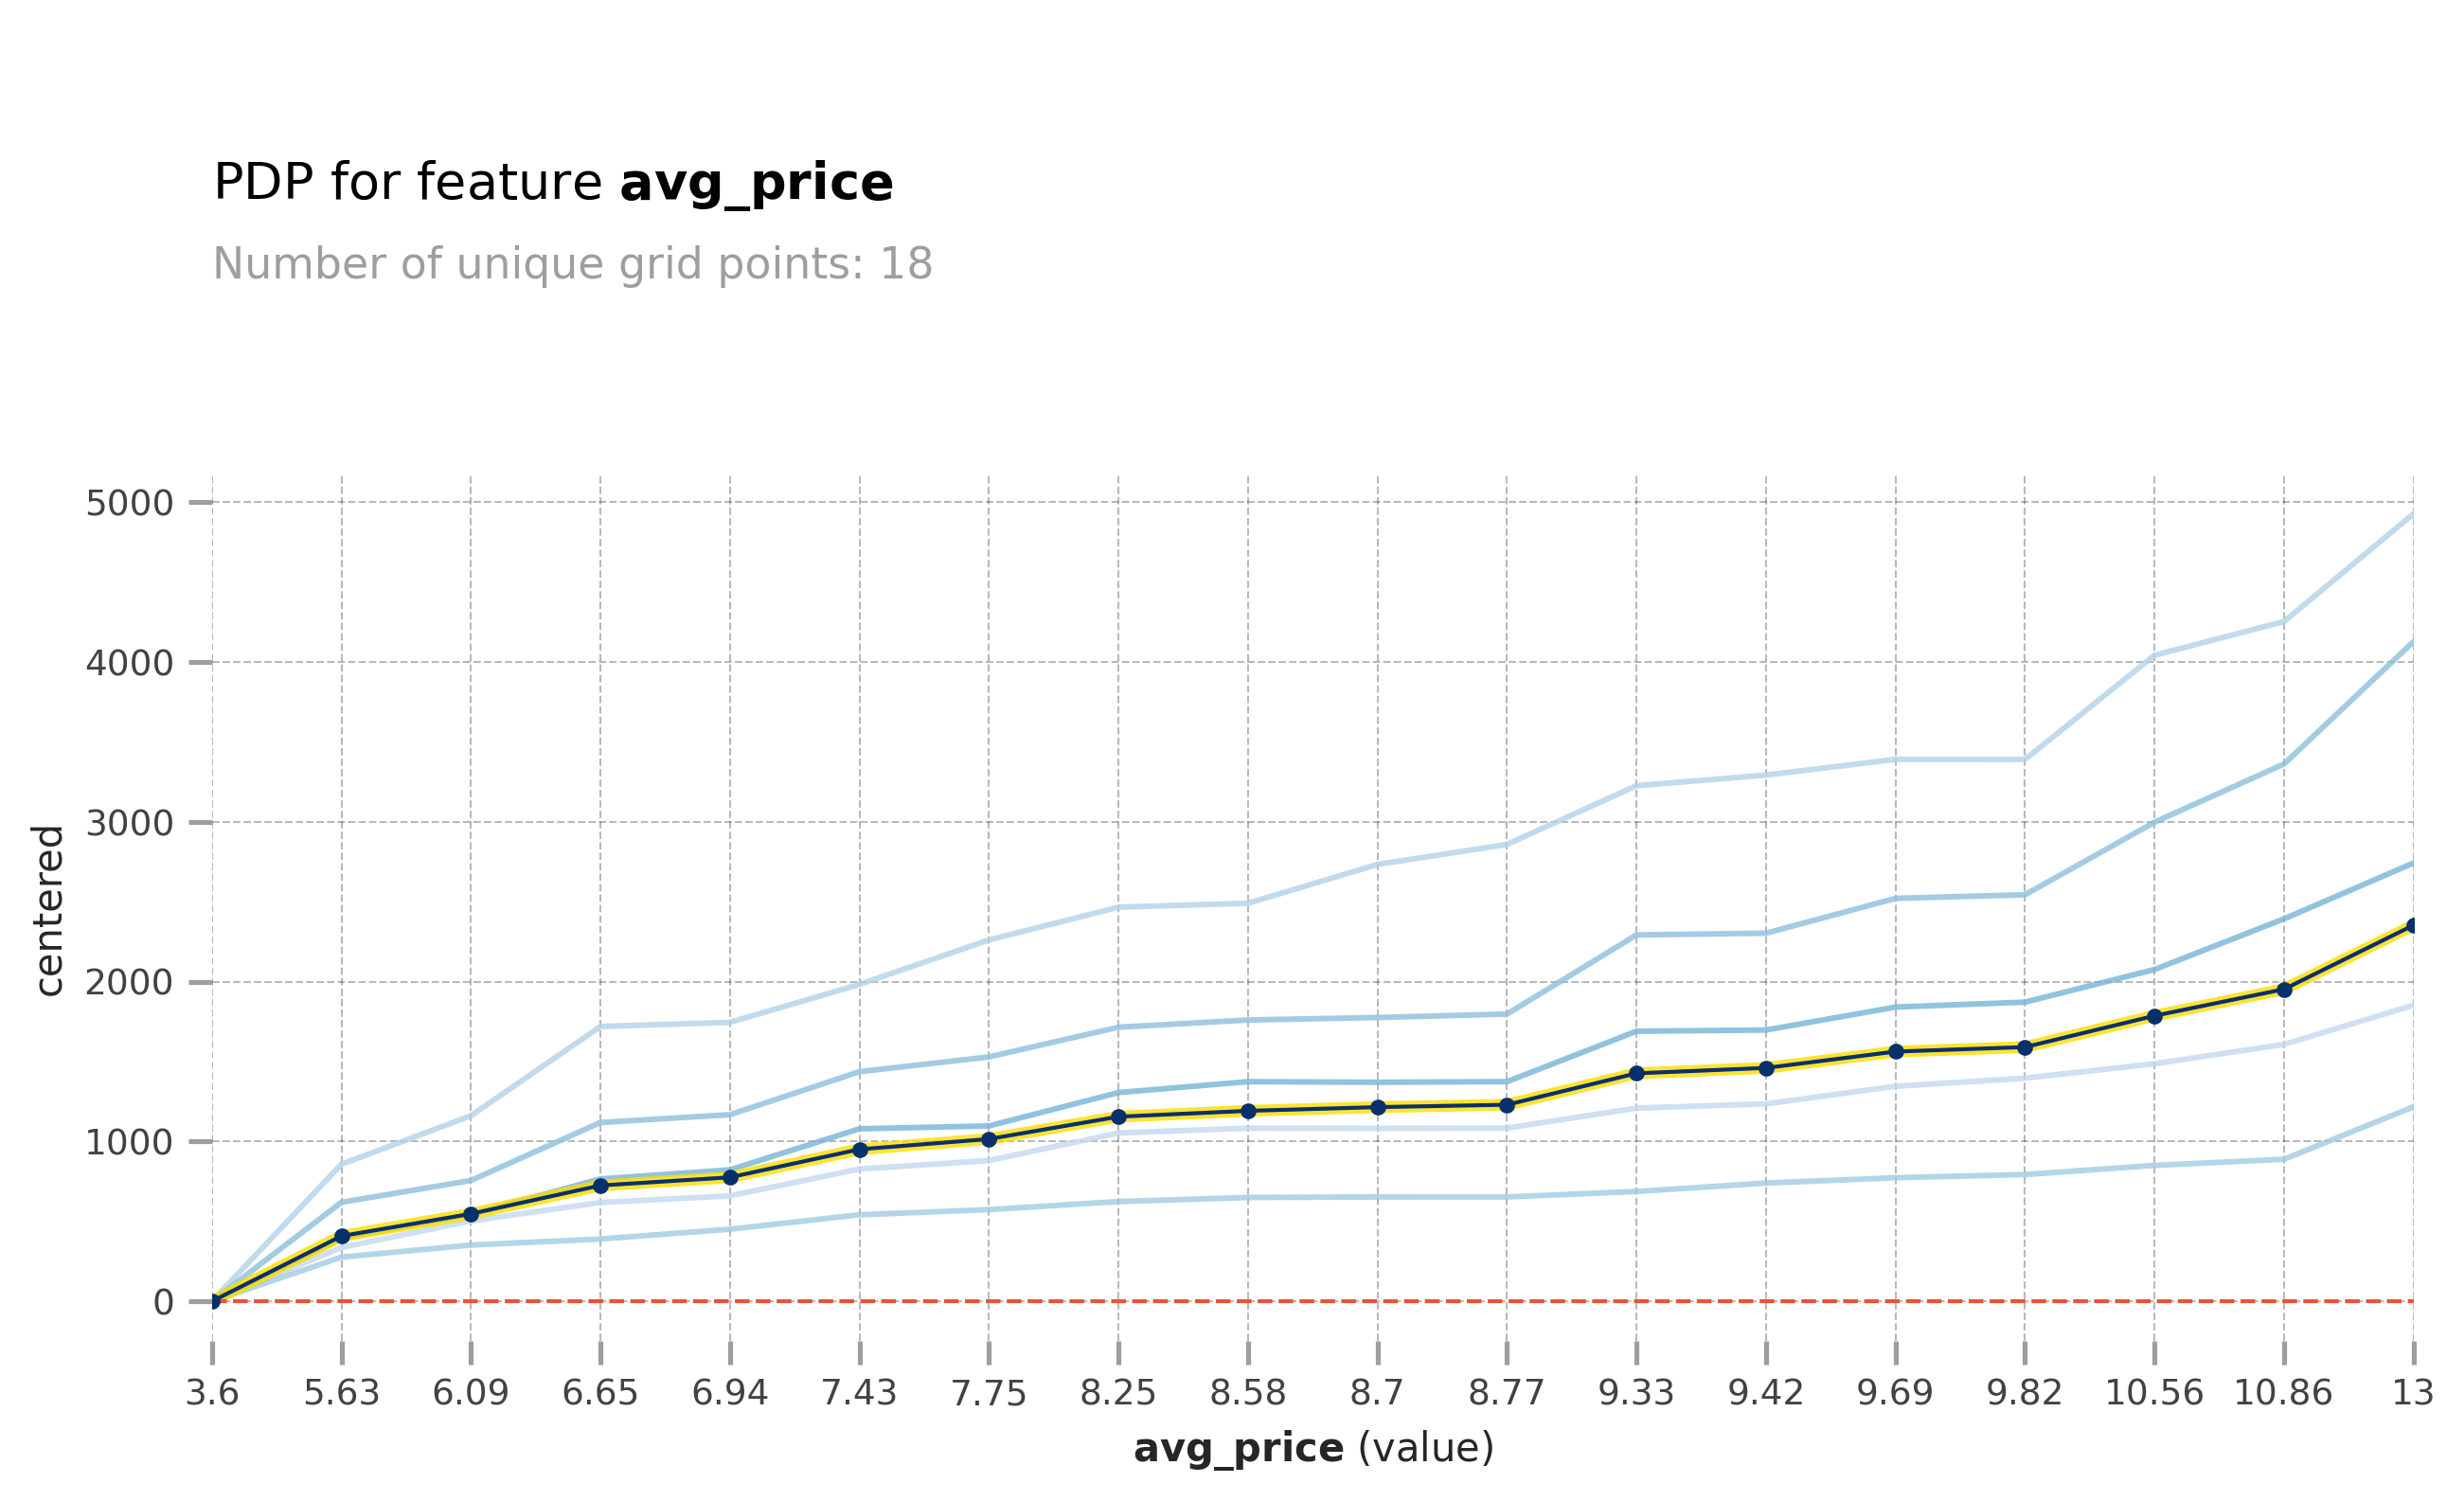

In [159]:
pdp_ice_plot(best_xgb_regressor, test_x, 'avg_price', clusters=True)

>The higher the avg_price, also the higher the price, but not all data is affected the same, some are highly affected, some are less affected.

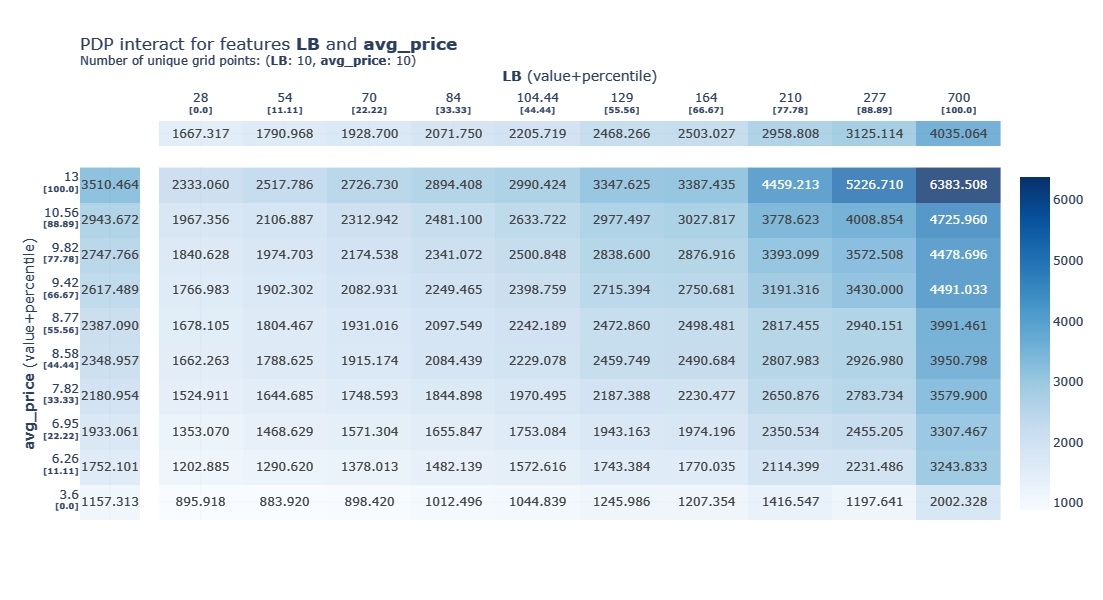

In [160]:
fig, axes = pdp_interact.plot(
    plot_type="grid",
    to_bins=True,
    plot_pdp=True,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params=None,
    engine="plotly",
    template="plotly_white",
)
fig

>By combining the avg_price and the LT, you can see that low LT is not affected as much as it affect high LT. The price is more volatile on higher LT.

## Conclusion

I have concerns regarding the model's accuracy, primarily because the residuals are still to be relatively high. This issue can be attributed to the limited sample size and the exclusion of critical factors influencing prices. Among these factors, 'avg_price' is of utmost importance. To enhance the accuracy of 'avg_price,' it's imperative to expand the sample size and consider a broader spectrum of variables affecting prices. While I've used 'Kecamatan' and 'Kondisi Perabotan' in this context to estimate 'avg_price,' I believe these variables alone are insufficient. Moving forward, I plan to further develop this project by gathering additional data from various real estate websites to create a more robust and accurate model.